# Part I: Set Up

- Import Packages

In [33]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import os
from statistics import mean
from keras import backend as K
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
import matplotlib.pyplot as plt
from mosek.fusion import *

- Initialize Variables

In [8]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
os.chdir("/Users/youssefberrada/Dropbox (MIT)/15.961 Independant Study/Data")
#os.chdir("/Users/michelcassard/Dropbox (MIT)/15.960 Independant Study/Data")
file = 'FX-5.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)
close = pd.ExcelFile('close.xlsx')
df_close=np.array(close.parse(0))

# Part 2: Data

- Load Data

In [9]:
def get_stock_data(stock_name, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    
    """
    df = xl.parse(stock_name)
    df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)
     # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
  
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

- Visualize the data

In [10]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

- Training/Test Set

In [22]:
def load_data(stock,normalize,seq_len,split,ma):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    sequence_length = seq_len+1
    result_train = []
    result_test= []
    row = round(split * stock.shape[0])
    df_train=stock[0:row].copy()
    print ("Amount of training data = {}".format(df_train.shape[0]))
    df_test=stock[row:len(stock)].copy()
    print ("Amount of testing data = {}".format(df_test.shape[0]))


    if normalize:
        #Training
        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Open'] = min_max_scaler.transform(df_train['Open'].values.reshape(-1,1))
        df_train['High'] = min_max_scaler.transform(df_train['High'].values.reshape(-1,1))
        df_train['Low'] = min_max_scaler.transform(df_train['Low'].values.reshape(-1,1))
        df_train['Adj Close'] = min_max_scaler.transform(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Volume'] = min_max_scaler.fit_transform(df_train.Volume.values.reshape(-1,1))
        df_train['Pct'] = min_max_scaler.fit_transform(df_train['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_train['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma'.format(moving)].values.reshape(-1,1))
        #Test
        min_max_scaler.fit(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Open'] = min_max_scaler.transform(df_test['Open'].values.reshape(-1,1))
        df_test['High'] = min_max_scaler.transform(df_test['High'].values.reshape(-1,1))
        df_test['Low'] = min_max_scaler.transform(df_test['Low'].values.reshape(-1,1))
        df_test['Adj Close'] = min_max_scaler.transform(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Volume'] = min_max_scaler.fit_transform(df_test.Volume.values.reshape(-1,1))
        df_test['Pct'] = min_max_scaler.fit_transform(df_test['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_test['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma'.format(moving)].values.reshape(-1,1))

    #Training
    data_train = df_train.as_matrix()
    for index in range(len(data_train) - sequence_length):
        result_train.append(data_train[index: index + sequence_length])
    train = np.array(result_train)
    X_train = train[:, :-1].copy() # all data until day m
    y_train = train[:, -1][:,-1].copy() # day m + 1 adjusted close price

    #Test
    data_test = df_test.as_matrix()
    for index in range(len(data_test) - sequence_length):
        result_test.append(data_test[index: index + sequence_length])
    test = np.array(result_train)
    X_test = test[:, :-1].copy()
    y_test = test[:, -1][:,-1].copy()


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

# 3. Model

In [12]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    #model.add(Dense(neurons[0],activation="relu", input_shape=(shape[0], shape[1])))
    
    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [13]:
def build_model_CNN(shape, neurons, dropout, decay):
    model = Sequential()
    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(250))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('linear'))
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
model = build_model_CNN(shape, neurons, dropout, decay)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
___________________________________________________________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


# 4. Results

- Model Fit

In [56]:
model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)

Train on 9782 samples, validate on 4193 samples
Epoch 1/90
9782/9782 [==============================] - 2s 157us/step - loss: 0.0300 - acc: 1.0223e-04 - val_loss: 0.0027 - val_acc: 2.3849e-04
Epoch 2/90
9782/9782 [==============================] - 0s 45us/step - loss: 0.0062 - acc: 1.0223e-04 - val_loss: 8.3929e-04 - val_acc: 2.3849e-04
Epoch 3/90
9782/9782 [==============================] - 0s 46us/step - loss: 0.0040 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 4/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0031 - acc: 1.0223e-04 - val_loss: 0.0017 - val_acc: 2.3849e-04
Epoch 5/90
9782/9782 [==============================] - 0s 44us/step - loss: 0.0025 - acc: 1.0223e-04 - val_loss: 0.0021 - val_acc: 2.3849e-04
Epoch 6/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0023 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 7/90
9782/9782 [==============================] - 1s 57us/step - loss: 0.0019 - acc

- Model Score

In [15]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [58]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00037 MSE (0.02 RMSE)
Test Score: 0.00037 MSE (0.02 RMSE)


(0.0003710565636182714, 0.0003710565636182714)

In [16]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    print(mean(percentage_diff))
    return p

In [60]:
p = percentage_difference(model, X_test, y_test)

-57.38379361472257


In [17]:
def plot_result_norm(stock_name, normalized_value_p, normalized_value_y_test):
    newp=normalized_value_p
    newy_test=normalized_value_y_test
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

In [18]:
def denormalize(stock_name, normalized_value,split=0.7,predict=True):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = xl.parse(stock_name)
    df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)


    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    row = round(split * df.shape[0]) 
    if predict:
        df_p=df[0:row].copy()
    else:
        df_p=df[row:len(df)].copy()
    
    #return df.shape, p.shape
    max_df=np.max(df_p)
    min_df=np.min(df_p)
    new=normalized_value*(max_df-min_df)+min_df
      
    return new

- Portfolio construction

In [19]:
def portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7):
    i=0
    mini=99999999
    for currency in currency_list:
        df=get_stock_data(currency,  ma)
        X_train, y_train, X_test, y_test = load_data(df,True,seq_len,split,ma)
        model = build_model_CNN(shape, neurons, dropout, decay)
        model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)
        p = percentage_difference(model, X_test, y_test)
        newp = denormalize(currency, p,predict=True)
        if mini>p.size:
            mini=p.size
        if i==0:
            predict=newp.copy()
        else:
            predict=np.hstack((predict[0:mini],newp[0:mini]))
        i+=1
    return predict



In [24]:
currency_list=[ 'GBP Curncy',
 'JPY Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']
predictcur=portfolio(currency_list,file = 'FX-5-merg.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7)

Amount of features = 9
Amount of training data = 13998
Amount of testing data = 5999


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               64250     
__________

Epoch 45/90
9782/9782 [==============================] - 0s 44us/step - loss: 9.0455e-04 - acc: 1.0223e-04 - val_loss: 0.0017 - val_acc: 2.3849e-04
Epoch 46/90
9782/9782 [==============================] - 0s 44us/step - loss: 8.9184e-04 - acc: 1.0223e-04 - val_loss: 0.0013 - val_acc: 2.3849e-04
Epoch 47/90
9782/9782 [==============================] - 0s 43us/step - loss: 8.7135e-04 - acc: 1.0223e-04 - val_loss: 0.0011 - val_acc: 2.3849e-04
Epoch 48/90
9782/9782 [==============================] - 0s 45us/step - loss: 9.0731e-04 - acc: 1.0223e-04 - val_loss: 9.3832e-04 - val_acc: 2.3849e-04
Epoch 49/90
9782/9782 [==============================] - 0s 43us/step - loss: 8.8111e-04 - acc: 1.0223e-04 - val_loss: 7.8026e-04 - val_acc: 2.3849e-04
Epoch 50/90
9782/9782 [==============================] - 0s 47us/step - loss: 8.6902e-04 - acc: 1.0223e-04 - val_loss: 7.5827e-04 - val_acc: 2.3849e-04
Epoch 51/90
9782/9782 [==============================] - 0s 44us/step - loss: 8.4785e-04 - acc: 1.02

Train on 9786 samples, validate on 4194 samples
Epoch 1/90
9786/9786 [==============================] - 1s 108us/step - loss: 0.0749 - acc: 1.0219e-04 - val_loss: 0.0085 - val_acc: 2.3844e-04
Epoch 2/90
9786/9786 [==============================] - 0s 44us/step - loss: 0.0104 - acc: 1.0219e-04 - val_loss: 0.0022 - val_acc: 2.3844e-04
Epoch 3/90
9786/9786 [==============================] - 0s 45us/step - loss: 0.0071 - acc: 1.0219e-04 - val_loss: 0.0021 - val_acc: 2.3844e-04
Epoch 4/90
9786/9786 [==============================] - 0s 42us/step - loss: 0.0058 - acc: 1.0219e-04 - val_loss: 0.0015 - val_acc: 2.3844e-04
Epoch 5/90
9786/9786 [==============================] - 0s 44us/step - loss: 0.0048 - acc: 1.0219e-04 - val_loss: 0.0012 - val_acc: 2.3844e-04
Epoch 6/90
9786/9786 [==============================] - 0s 45us/step - loss: 0.0042 - acc: 1.0219e-04 - val_loss: 0.0012 - val_acc: 2.3844e-04
Epoch 7/90
9786/9786 [==============================] - 0s 48us/step - loss: 0.0038 - acc: 1.

9804/9804 [==============================] - 0s 44us/step - loss: 0.0017 - acc: 1.0200e-04 - val_loss: 0.0028 - val_acc: 2.3798e-04
Epoch 11/90
9804/9804 [==============================] - 0s 45us/step - loss: 0.0016 - acc: 1.0200e-04 - val_loss: 0.0055 - val_acc: 2.3798e-04
Epoch 12/90
9804/9804 [==============================] - 0s 47us/step - loss: 0.0016 - acc: 1.0200e-04 - val_loss: 0.0029 - val_acc: 2.3798e-04
Epoch 13/90
9804/9804 [==============================] - 0s 45us/step - loss: 0.0015 - acc: 1.0200e-04 - val_loss: 0.0030 - val_acc: 2.3798e-04
Epoch 14/90
9804/9804 [==============================] - 0s 45us/step - loss: 0.0015 - acc: 1.0200e-04 - val_loss: 0.0041 - val_acc: 2.3798e-04
Epoch 15/90
9804/9804 [==============================] - 0s 45us/step - loss: 0.0014 - acc: 1.0200e-04 - val_loss: 0.0051 - val_acc: 2.3798e-04
Epoch 16/90
9804/9804 [==============================] - 0s 43us/step - loss: 0.0014 - acc: 1.0200e-04 - val_loss: 0.0023 - val_acc: 2.3798e-04
Epoc

Epoch 66/90
9804/9804 [==============================] - 1s 54us/step - loss: 8.2635e-04 - acc: 1.0200e-04 - val_loss: 0.0010 - val_acc: 2.3798e-04
Epoch 67/90
9804/9804 [==============================] - 1s 54us/step - loss: 8.5864e-04 - acc: 1.0200e-04 - val_loss: 7.6646e-04 - val_acc: 2.3798e-04
Epoch 68/90
9804/9804 [==============================] - 1s 51us/step - loss: 8.1438e-04 - acc: 1.0200e-04 - val_loss: 4.7876e-04 - val_acc: 2.3798e-04
Epoch 69/90
9804/9804 [==============================] - 0s 45us/step - loss: 8.0597e-04 - acc: 1.0200e-04 - val_loss: 4.5276e-04 - val_acc: 2.3798e-04
Epoch 70/90
9804/9804 [==============================] - 0s 46us/step - loss: 7.9406e-04 - acc: 1.0200e-04 - val_loss: 4.6381e-04 - val_acc: 2.3798e-04
Epoch 71/90
9804/9804 [==============================] - 0s 46us/step - loss: 7.8407e-04 - acc: 1.0200e-04 - val_loss: 3.9830e-04 - val_acc: 2.3798e-04
Epoch 72/90
9804/9804 [==============================] - 1s 51us/step - loss: 8.2147e-04 - a

Epoch 74/90
9763/9763 [==============================] - 0s 42us/step - loss: 0.0011 - acc: 2.0486e-04 - val_loss: 4.7749e-04 - val_acc: 0.0000e+00
Epoch 75/90
9763/9763 [==============================] - 0s 43us/step - loss: 0.0012 - acc: 2.0486e-04 - val_loss: 2.8847e-04 - val_acc: 0.0000e+00
Epoch 76/90
9763/9763 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0486e-04 - val_loss: 7.4451e-04 - val_acc: 0.0000e+00
Epoch 77/90
9763/9763 [==============================] - 0s 43us/step - loss: 0.0012 - acc: 2.0486e-04 - val_loss: 2.6065e-04 - val_acc: 0.0000e+00
Epoch 78/90
9763/9763 [==============================] - 0s 42us/step - loss: 0.0011 - acc: 2.0486e-04 - val_loss: 3.5504e-04 - val_acc: 0.0000e+00
Epoch 79/90
9763/9763 [==============================] - 0s 44us/step - loss: 0.0011 - acc: 2.0486e-04 - val_loss: 3.2185e-04 - val_acc: 0.0000e+00
Epoch 80/90
9763/9763 [==============================] - 0s 45us/step - loss: 0.0011 - acc: 2.0486e-04 - val_los

Epoch 83/90
9789/9789 [==============================] - 0s 48us/step - loss: 0.0011 - acc: 2.0431e-04 - val_loss: 0.0016 - val_acc: 7.1497e-04
Epoch 84/90
9789/9789 [==============================] - 0s 48us/step - loss: 0.0011 - acc: 2.0431e-04 - val_loss: 0.0013 - val_acc: 7.1497e-04
Epoch 85/90
9789/9789 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 2.0431e-04 - val_loss: 0.0015 - val_acc: 7.1497e-04
Epoch 86/90
9789/9789 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0431e-04 - val_loss: 0.0015 - val_acc: 7.1497e-04
Epoch 87/90
9789/9789 [==============================] - 0s 44us/step - loss: 0.0010 - acc: 2.0431e-04 - val_loss: 0.0015 - val_acc: 7.1497e-04
Epoch 88/90
9789/9789 [==============================] - 0s 46us/step - loss: 0.0011 - acc: 2.0431e-04 - val_loss: 0.0014 - val_acc: 7.1497e-04
Epoch 89/90
9789/9789 [==============================] - 0s 44us/step - loss: 0.0011 - acc: 2.0431e-04 - val_loss: 0.0013 - val_acc: 7.1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 250)               64250     
__________

Train on 9777 samples, validate on 4191 samples
Epoch 1/90
9777/9777 [==============================] - 1s 133us/step - loss: 0.0501 - acc: 4.0912e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/90
9777/9777 [==============================] - 0s 43us/step - loss: 0.0103 - acc: 4.0912e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/90
9777/9777 [==============================] - 0s 43us/step - loss: 0.0067 - acc: 4.0912e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 4/90
9777/9777 [==============================] - 0s 44us/step - loss: 0.0052 - acc: 4.0912e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 5/90
9777/9777 [==============================] - 0s 43us/step - loss: 0.0044 - acc: 4.0912e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 6/90
9777/9777 [==============================] - 0s 43us/step - loss: 0.0039 - acc: 4.0912e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 7/90
9777/9777 [==============================] - 0s 43us/step - loss: 0.0035 - acc: 4.

9787/9787 [==============================] - 0s 50us/step - loss: 0.0016 - acc: 1.0218e-04 - val_loss: 9.7289e-04 - val_acc: 2.3838e-04
Epoch 9/90
9787/9787 [==============================] - 0s 48us/step - loss: 0.0015 - acc: 1.0218e-04 - val_loss: 0.0016 - val_acc: 2.3838e-04
Epoch 10/90
9787/9787 [==============================] - 0s 49us/step - loss: 0.0015 - acc: 1.0218e-04 - val_loss: 0.0011 - val_acc: 2.3838e-04
Epoch 11/90
9787/9787 [==============================] - 0s 50us/step - loss: 0.0014 - acc: 1.0218e-04 - val_loss: 0.0015 - val_acc: 2.3838e-04
Epoch 12/90
9787/9787 [==============================] - 0s 50us/step - loss: 0.0014 - acc: 1.0218e-04 - val_loss: 0.0015 - val_acc: 2.3838e-04
Epoch 13/90
9787/9787 [==============================] - 0s 49us/step - loss: 0.0013 - acc: 1.0218e-04 - val_loss: 0.0021 - val_acc: 2.3838e-04
Epoch 14/90
9787/9787 [==============================] - 0s 47us/step - loss: 0.0013 - acc: 1.0218e-04 - val_loss: 0.0011 - val_acc: 2.3838e-04
E

Epoch 64/90
9787/9787 [==============================] - 0s 46us/step - loss: 7.4499e-04 - acc: 1.0218e-04 - val_loss: 0.0013 - val_acc: 2.3838e-04
Epoch 65/90
9787/9787 [==============================] - 0s 46us/step - loss: 7.4429e-04 - acc: 1.0218e-04 - val_loss: 0.0014 - val_acc: 2.3838e-04
Epoch 66/90
9787/9787 [==============================] - 0s 44us/step - loss: 6.9825e-04 - acc: 1.0218e-04 - val_loss: 0.0015 - val_acc: 2.3838e-04
Epoch 67/90
9787/9787 [==============================] - 0s 46us/step - loss: 7.2739e-04 - acc: 1.0218e-04 - val_loss: 0.0024 - val_acc: 2.3838e-04
Epoch 68/90
9787/9787 [==============================] - 0s 47us/step - loss: 7.5395e-04 - acc: 1.0218e-04 - val_loss: 0.0016 - val_acc: 2.3838e-04
Epoch 69/90
9787/9787 [==============================] - 0s 46us/step - loss: 7.3775e-04 - acc: 1.0218e-04 - val_loss: 9.8171e-04 - val_acc: 2.3838e-04
Epoch 70/90
9787/9787 [==============================] - 0s 46us/step - loss: 7.2520e-04 - acc: 1.0218e-04 -

Epoch 71/90
9629/9629 [==============================] - 0s 46us/step - loss: 7.9519e-04 - acc: 1.0385e-04 - val_loss: 8.5566e-04 - val_acc: 2.4231e-04
Epoch 72/90
9629/9629 [==============================] - 0s 46us/step - loss: 7.4299e-04 - acc: 1.0385e-04 - val_loss: 4.2628e-04 - val_acc: 2.4231e-04
Epoch 73/90
9629/9629 [==============================] - 0s 45us/step - loss: 7.4136e-04 - acc: 1.0385e-04 - val_loss: 5.0463e-04 - val_acc: 2.4231e-04
Epoch 74/90
9629/9629 [==============================] - 0s 46us/step - loss: 7.1988e-04 - acc: 1.0385e-04 - val_loss: 4.4752e-04 - val_acc: 2.4231e-04
Epoch 75/90
9629/9629 [==============================] - 0s 44us/step - loss: 7.3760e-04 - acc: 1.0385e-04 - val_loss: 3.7105e-04 - val_acc: 2.4231e-04
Epoch 76/90
9629/9629 [==============================] - 0s 43us/step - loss: 7.9357e-04 - acc: 1.0385e-04 - val_loss: 5.5198e-04 - val_acc: 2.4231e-04
Epoch 77/90
9629/9629 [==============================] - 0s 44us/step - loss: 7.2245e-04

In [30]:
def MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g):
    # Upper bound on the traded amount
    w0 = w+sum(x0)
    u = n*[w0]

    with Model("Markowitz portfolio with transaction costs") as M:
        #M.setLogHandler(sys.stdout)

        # Defines the variables. No shortselling is allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0))

        # Additional "helper" variables 
        z = M.variable("z", n, Domain.unbounded())   
        # Binary variables
        y = M.variable("y", n, Domain.binary())

        #  Maximize expected return
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        # Invest amount + transactions costs = initial wealth
        M.constraint('budget', Expr.add([ Expr.sum(x), Expr.dot(f,y),Expr.dot(g,z)] ), Domain.equalsTo(w0))

        # Imposes a bound on the risk
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        # z >= |x-x0| 
        M.constraint('buy', Expr.sub(z,Expr.sub(x,x0)),Domain.greaterThan(0.0))
        M.constraint('sell', Expr.sub(z,Expr.sub(x0,x)),Domain.greaterThan(0.0))
        # Alternatively, formulate the two constraints as
        #M.constraint('trade', Expr.hstack(z,Expr.sub(x,x0)), Domain.inQcone())

        # Constraints for turning y off and on. z-diag(u)*y<=0 i.e. z_j <= u_j*y_j
        M.constraint('y_on_off', Expr.sub(z,Expr.mulElm(u,y)), Domain.lessThan(0.0))

        # Integer optimization problems can be very hard to solve so limiting the 
        # maximum amount of time is a valuable safe guard
        M.setSolverParam('mioMaxTime', 1000.0) 
        M.solve()

        return (np.dot(mu,x.level()), x.level())

- Backtest

In [25]:
def rebalance(n,previous_prices,x0,w,mu,gamma=1):
    GT=np.cov(previous_prices)
    f = n*[0.0001]
    g = n*[0.0005]
    _,weights=MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g)
    return weights

In [26]:
def log_diff(data):
    return np.diff(np.log(data))

In [31]:
def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions)
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    port_return=1
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[k]/prices[:,length_past+k-1]))
    weights = initial_weights
    portfolio_return = []
    prev_weight = weights
    for i in range(0,t_predictions-1):
        print(i)
        predicted_return = prediction_return[i]
        previous_return = returns[:,length_past+i-1]
        previous_returns = returns[:,0:(length_past+i-1)]
        if i==0:
            new_weight = rebalance(10,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=1,gamma=0.05)
        else:
            new_weight = rebalance(10,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=np.sum(period_return),gamma=0.05)
        period_return = new_weight*np.log(prices[:,length_past+i]/prices[:,length_past+i-1])
        port_return=port_return*(1+np.sum(period_return))
        portfolio_return.append(port_return)
        prev_weight = new_weight
        print(new_weight)
    return portfolio_return

In [34]:
x=backtest(df_close.T, predictcur, np.repeat(1/10,10))

0
[1.13863027e-11 5.16121104e-12 6.57587464e-12 4.35747787e-12
 1.99760120e+00 5.50084590e-12 9.96409109e-12 4.56300688e-12
 4.85182431e-12 4.12988216e-12]
1
[0.         0.         0.         0.         1.99836936 0.
 0.         0.         0.         0.        ]
2
[0.         0.         0.         0.         1.99855853 0.
 0.         0.         0.         0.        ]
3
[0.         0.         0.         0.         1.99961599 0.
 0.         0.         0.         0.        ]
4
[0.         0.         0.         0.         1.99864587 0.
 0.         0.         0.         0.        ]
5
[0.         0.         0.         0.         1.99883499 0.
 0.         0.         0.         0.        ]
6
[0.         0.         0.         0.         1.99902411 0.
 0.         0.         0.         0.        ]
7
[0.         0.         0.         0.         1.99747424 0.
 0.         0.         0.         0.        ]
8
[0.         0.         0.         0.         1.99747424 0.
 0.         0.         0.         

[0.        0.        0.        0.        1.9897772 0.        0.
 0.        0.        0.       ]
86
[0.         0.         0.         0.         1.99054233 0.
 0.         0.         0.         0.        ]
87
[0.         0.         0.         0.         1.99073049 0.
 0.         0.         0.         0.        ]
88
[0.         0.         0.         0.         1.99034116 0.
 0.         0.         0.         0.        ]
89
[0.         0.         0.         0.         1.98995184 0.
 0.         0.         0.         0.        ]
90
[0.        0.        0.        0.        1.9904284 0.        0.
 0.        0.        0.       ]
91
[0.         0.         0.         0.         1.99148164 0.
 0.         0.         0.         0.        ]
92
[0.         0.         0.         0.         1.99224651 0.
 0.         0.         0.         0.        ]
93
[0.         0.         0.         0.         1.99243458 0.
 0.         0.         0.         0.        ]
94
[0.         0.         0.         0.         1

[0.         0.         0.         0.         1.98185379 0.
 0.         0.         0.         0.        ]
169
[0.         0.         0.         0.         1.98031366 0.
 0.         0.         0.         0.        ]
170
[0.         0.         0.         0.         1.97992534 0.
 0.         0.         0.         0.        ]
171
[0.         0.         0.         0.         1.97992534 0.
 0.         0.         0.         0.        ]
172
[0.         0.         0.         0.         1.98011246 0.
 0.         0.         0.         0.        ]
173
[0.         0.         0.         0.         1.97914844 0.
 0.         0.         0.         0.        ]
174
[ 1.26519426e-10  0.00000000e+00  7.31713499e-11  0.00000000e+00
  1.97914843e+00  0.00000000e+00  1.70293329e-10  0.00000000e+00
  0.00000000e+00 -1.62899862e-11]
175
[0.         0.         0.         0.         1.97933552 0.
 0.         0.         0.         0.        ]
176
[0.         0.         0.         0.         1.98009736 0.
 0.       

[0.         0.         0.         0.         1.96952448 0.
 0.         0.         0.         0.        ]
252
[0.         0.         0.         0.         1.96971062 0.
 0.         0.         0.         0.        ]
253
[0.         0.         0.         0.         1.96989676 0.
 0.         0.         0.         0.        ]
254
[0.         0.         0.         0.         1.96922259 0.
 0.         0.         0.         0.        ]
255
[0.         0.         0.         0.         1.96969512 0.
 0.         0.         0.         0.        ]
256
[2.32696074e-12 1.63969761e-12 1.66112421e-12 1.01972703e-12
 1.96969512e+00 1.58679411e-12 3.51934961e-12 1.38421980e-12
 1.44658089e-12 3.95309675e-13]
257
[1.96529890e-12 1.38618627e-12 1.37543654e-12 8.40769252e-13
 1.96969512e+00 1.34646708e-12 3.10078921e-12 1.15529051e-12
 1.21452789e-12 3.36574039e-13]
258
[0.         0.         0.         0.         1.96902101 0.
 0.         0.         0.         0.        ]
259
[7.61883206e-13 5.57590616e-13

[0.         0.         0.         0.         1.96972176 0.
 0.         0.         0.         0.        ]
325
[0.         0.         0.         0.         1.96990714 0.
 0.         0.         0.         0.        ]
326
[0.         0.         0.         0.         1.97009251 0.
 0.         0.         0.         0.        ]
327
[0.         0.         0.         0.         1.96970597 0.
 0.         0.         0.         0.        ]
328
[0.         0.         0.         0.         1.96931944 0.
 0.         0.         0.         0.        ]
329
[0.         0.         0.         0.         1.96893292 0.
 0.         0.         0.         0.        ]
330
[0.         0.         0.         0.         1.96854642 0.
 0.         0.         0.         0.        ]
331
[5.97471537e-12 3.93219648e-12 4.27728844e-12 2.87392990e-12
 1.96854642e+00 3.87677294e-12 9.62521536e-12 3.12939132e-12
 3.61104761e-12 1.09004513e-12]
332
[3.09569255e-12 2.07436450e-12 2.23533521e-12 1.50797492e-12
 1.96854642e+00 2.

[0.         0.         0.         0.         1.96486034 0.
 0.         0.         0.         0.        ]
398
[0.         0.         0.         0.         1.96504499 0.
 0.         0.         0.         0.        ]
399
[0.         0.         0.         0.         1.96437381 0.
 0.         0.         0.         0.        ]
400
[0.         0.         0.         0.         1.96455843 0.
 0.         0.         0.         0.        ]
401
[0.         0.         0.         0.         1.96474302 0.
 0.         0.         0.         0.        ]
402
[0.         0.         0.         0.         1.96492761 0.
 0.         0.         0.         0.        ]
403
[0.         0.         0.         0.         1.96454186 0.
 0.         0.         0.         0.        ]
404
[1.16435639e-12 8.19055468e-13 8.15458903e-13 5.78773611e-13
 1.96454186e+00 7.90839012e-13 1.75544622e-12 6.39878888e-13
 7.37312344e-13 2.28993517e-13]
405
[0.         0.         0.         0.         1.96387083 0.
 0.         0.      

[0.         0.         0.         0.         1.95313763 0.
 0.         0.         0.         0.        ]
483
[0.         0.         0.         0.         1.95218414 0.
 0.         0.         0.         0.        ]
484
[1.58237383e-12 1.00150639e-12 1.06237842e-12 7.44092550e-13
 1.95218414e+00 9.47930633e-13 1.82032942e-12 7.98356804e-13
 8.99194031e-13 2.35996564e-13]
485
[0.         0.         0.         0.         1.95037736 0.
 0.         0.         0.         0.        ]
486
[0.         0.         0.         0.         1.95056093 0.
 0.         0.         0.         0.        ]
487
[0.         0.         0.         0.         1.95131222 0.
 0.         0.         0.         0.        ]
488
[0.         0.         0.         0.         1.95064322 0.
 0.         0.         0.         0.        ]
489
[0.         0.         0.         0.         1.95111061 0.
 0.         0.         0.         0.        ]
490
[7.63612794e-11 4.79468249e-11 5.16323111e-11 3.46406614e-11
 1.95111061e+00 4.

[0.         0.         0.         0.         1.93660433 0.
 0.         0.         0.         0.        ]
567
[0.         0.         0.         0.         1.93678688 0.
 0.         0.         0.         0.        ]
568
[0.         0.         0.         0.         1.93611988 0.
 0.         0.         0.         0.        ]
569
[0.        0.        0.        0.        1.9354529 0.        0.
 0.        0.        0.       ]
570
[0.        0.        0.        0.        1.9356354 0.        0.
 0.        0.        0.       ]
571
[6.76529487e-10 0.00000000e+00 5.37782467e-10 0.00000000e+00
 1.93563538e+00 0.00000000e+00 8.39457338e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
572
[0.         0.         0.         0.         1.93666621 0.
 0.         0.         0.         0.        ]
573
[6.64262172e-10 0.00000000e+00 5.20618389e-10 0.00000000e+00
 1.93666619e+00 0.00000000e+00 8.07169018e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
574
[6.84773294e-10 0.00000000e+00 5.30717749e-10 0.

[0.         0.         0.         0.         1.92948476 0.
 0.         0.         0.         0.        ]
638
[0.         0.         0.         0.         1.93107679 0.
 0.         0.         0.         0.        ]
639
[0.         0.         0.         0.         1.93125857 0.
 0.         0.         0.         0.        ]
640
[0.        0.        0.        0.        1.9308756 0.        0.
 0.        0.        0.       ]
641
[3.66512158e-10 0.00000000e+00 2.86456384e-10 0.00000000e+00
 1.93087559e+00 0.00000000e+00 4.81269280e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
642
[0.        0.        0.        0.        1.9299276 0.        0.
 0.        0.        0.       ]
643
[2.94556691e-10 0.00000000e+00 2.31866026e-10 0.00000000e+00
 1.92992759e+00 0.00000000e+00 3.93212486e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
644
[0.         0.         0.         0.         1.92926217 0.
 0.         0.         0.         0.        ]
645
[2.39515897e-10 0.00000000e+00 1.89664312e-10 0.

[7.43789468e-10 0.00000000e+00 5.79139252e-10 0.00000000e+00
 1.92465368e+00 0.00000000e+00 1.06159205e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
709
[0.         0.         0.         0.         1.92624049 0.
 0.         0.         0.         0.        ]
710
[0.       0.       0.       0.       1.927265 0.       0.       0.
 0.       0.      ]
711
[0.        0.        0.        0.        1.9263196 0.        0.
 0.        0.        0.       ]
712
[0.        0.        0.        0.        1.9248108 0.        0.
 0.        0.        0.       ]
713
[0.         0.         0.         0.         1.92527287 0.
 0.         0.         0.         0.        ]
714
[7.04590160e-10 0.00000000e+00 5.58903568e-10 0.00000000e+00
 1.92527285e+00 0.00000000e+00 1.02295446e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
715
[0.         0.         0.         0.         1.92489081 0.
 0.         0.         0.         0.        ]
716
[0.         0.         0.         0.         1.92563395 0.
 0.    

[0.         0.         0.         0.         1.91765696 0.
 0.         0.         0.         0.        ]
793
[0.        0.        0.        0.        1.9158725 0.        0.
 0.        0.        0.       ]
794
[0.         0.         0.         0.         1.91605235 0.
 0.         0.         0.         0.        ]
795
[0.         0.         0.         0.         1.91735259 0.
 0.         0.         0.         0.        ]
796
[0.         0.         0.         0.         1.91584912 0.
 0.         0.         0.         0.        ]
797
[0.         0.         0.         0.         1.91630907 0.
 0.         0.         0.         0.        ]
798
[0.         0.         0.         0.         1.91536699 0.
 0.         0.         0.         0.        ]
799
[0.         0.         0.         0.         1.91610694 0.
 0.         0.         0.         0.        ]
800
[0.         0.         0.         0.         1.91768675 0.
 0.         0.         0.         0.        ]
801
[0.         0.         0.   

[0.         0.         0.         0.         1.92126317 0.
 0.         0.         0.         0.        ]
875
[0.         0.         0.         0.         1.92060341 0.
 0.         0.         0.         0.        ]
876
[0.         0.         0.         0.         1.92078232 0.
 0.         0.         0.         0.        ]
877
[0.         0.         0.         0.         1.92096122 0.
 0.         0.         0.         0.        ]
878
[0.        0.        0.        0.        1.9200219 0.        0.
 0.        0.        0.       ]
879
[0.         0.         0.         0.         1.91964185 0.
 0.         0.         0.         0.        ]
880
[ 2.27308409e-11  1.10180121e-11  2.20306412e-11  7.64948600e-12
  1.91964185e+00  7.73110635e-12  3.00089448e-11  6.86517203e-12
  7.40330064e-12 -4.25359248e-13]
881
[0.         0.         0.         0.         1.91982071 0.
 0.         0.         0.         0.        ]
882
[0.         0.         0.         0.         1.91999955 0.
 0.         0.     

[0.         0.         0.         0.         1.91023588 0.
 0.         0.         0.         0.        ]
945
[4.13849492e-10 0.00000000e+00 3.98716492e-10 0.00000000e+00
 1.91023587e+00 0.00000000e+00 5.30065906e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
946
[0.         0.         0.         0.         1.91069246 0.
 0.         0.         0.         0.        ]
947
[0.         0.         0.         0.         1.91003432 0.
 0.         0.         0.         0.        ]
948
[0.         0.         0.         0.         1.91049086 0.
 0.         0.         0.         0.        ]
949
[0.         0.         0.         0.         1.90983278 0.
 0.         0.         0.         0.        ]
950
[0.         0.         0.         0.         1.90945353 0.
 0.         0.         0.         0.        ]
951
[0.         0.         0.         0.         1.90823782 0.
 0.         0.         0.         0.        ]
952
[0.         0.         0.         0.         1.90841586 0.
 0.         0.      

[0.         0.         0.         0.         1.90260989 0.
 0.         0.         0.         0.        ]
1029
[0.         0.         0.         0.         1.90223162 0.
 0.         0.         0.         0.        ]
1030
[0.         0.         0.         0.         1.90129769 0.
 0.         0.         0.         0.        ]
1031
[0.         0.         0.         0.         1.90008594 0.
 0.         0.         0.         0.        ]
1032
[0.       0.       0.       0.       1.900263 0.       0.       0.
 0.       0.      ]
1033
[0.         0.         0.         0.         1.90044005 0.
 0.         0.         0.         0.        ]
1034
[0.         0.         0.         0.         1.90228061 0.
 0.         0.         0.         0.        ]
1035
[0.         0.         0.         0.         1.90384393 0.
 0.         0.         0.         0.        ]
1036
[0.         0.         0.         0.         1.90346577 0.
 0.         0.         0.         0.        ]
1037
[2.05110455e-11 1.19575020e-

[0.         0.         0.         0.         1.89739036 0.
 0.         0.         0.         0.        ]
1100
[0.         0.         0.         0.         1.89701298 0.
 0.         0.         0.         0.        ]
1101
[0.         0.         0.         0.         1.89663561 0.
 0.         0.         0.         0.        ]
1102
[0.         0.         0.         0.         1.89681181 0.
 0.         0.         0.         0.        ]
1103
[0.         0.         0.         0.         1.89643448 0.
 0.         0.         0.         0.        ]
1104
[0.         0.         0.         0.         1.89467232 0.
 0.         0.         0.         0.        ]
1105
[0.         0.         0.         0.         1.89650671 0.
 0.         0.         0.         0.        ]
1106
[0.         0.         0.         0.         1.89723574 0.
 0.         0.         0.         0.        ]
1107
[0.         0.         0.         0.         1.89723574 0.
 0.         0.         0.         0.        ]
1108
[0.       

[4.12120205e-11 3.35359154e-11 4.65967650e-11 2.18362122e-11
 1.89797703e+00 2.35257607e-11 6.82032229e-11 2.17091637e-11
 2.30256789e-11 8.44736946e-12]
1169
[4.21216185e-11 3.40779528e-11 4.71426976e-11 2.22221866e-11
 1.89797702e+00 2.37287973e-11 7.03205215e-11 2.20420581e-11
 2.33459260e-11 8.97120508e-12]
1170
[0.         0.         0.         0.         1.89842837 0.
 0.         0.         0.         0.        ]
1171
[0.         0.         0.         0.         1.89887968 0.
 0.         0.         0.         0.        ]
1172
[4.13029553e-11 3.31944610e-11 4.52760993e-11 2.20212213e-11
 1.89887968e+00 2.31871857e-11 6.76309288e-11 2.15167840e-11
 2.30410599e-11 8.92739776e-12]
1173
[ 9.39708305e-12  7.78606180e-12  1.03415319e-11  4.62471264e-12
  1.89887968e+00  5.06015698e-12  1.58052567e-11  4.51824261e-12
  4.96109170e-12 -4.68382278e-14]
1174
[0.         0.         0.         0.         1.89905516 0.
 0.         0.         0.         0.        ]
1175
[ 2.96777726e-12  2.2258

[0.         0.         0.         0.         1.88645148 0.
 0.         0.         0.         0.        ]
1241
[2.90659535e-10 0.00000000e+00 3.15807120e-10 0.00000000e+00
 1.88645147e+00 0.00000000e+00 4.96036136e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1242
[0.         0.         0.         0.         1.88662631 0.
 0.         0.         0.         0.        ]
1243
[1.69688795e-10 0.00000000e+00 1.85314038e-10 0.00000000e+00
 1.88662630e+00 0.00000000e+00 2.87025922e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1244
[0.         0.         0.         0.         1.88680112 0.
 0.         0.         0.         0.        ]
1245
[0.         0.         0.         0.         1.88614963 0.
 0.         0.         0.         0.        ]
1246
[0.         0.         0.         0.         1.88659954 0.
 0.         0.         0.         0.        ]
1247
[8.48461910e-11 0.00000000e+00 9.26336373e-11 0.00000000e+00
 1.88659953e+00 0.00000000e+00 1.43595368e-10 0.00000000e+00
 0.0000000

[0.         0.         0.         0.         1.88110626 0.
 0.         0.         0.         0.        ]
1312
[0.         0.         0.         0.         1.88018147 0.
 0.         0.         0.         0.        ]
1313
[0.         0.         0.         0.         1.88117847 0.
 0.         0.         0.         0.        ]
1314
[0.         0.         0.         0.         1.88190115 0.
 0.         0.         0.         0.        ]
1315
[0.        0.        0.        0.        1.8807017 0.        0.
 0.        0.        0.       ]
1316
[0.         0.         0.         0.         1.87950232 0.
 0.         0.         0.         0.        ]
1317
[0.         0.         0.         0.         1.88022487 0.
 0.         0.         0.         0.        ]
1318
[0.         0.         0.         0.         1.87875079 0.
 0.         0.         0.         0.        ]
1319
[ 2.22486351e-12  2.01576029e-12  2.56673812e-12  7.80822130e-13
  1.87875079e+00  9.25684092e-13  4.56441309e-12  9.28303474e-13

[3.17162946e-10 0.00000000e+00 3.84186939e-10 0.00000000e+00
 1.87023064e+00 0.00000000e+00 6.38862080e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1396
[0.         0.         0.         0.         1.86958264 0.
 0.         0.         0.         0.        ]
1397
[0.         0.         0.         0.         1.86975569 0.
 0.         0.         0.         0.        ]
1398
[0.         0.         0.         0.         1.87102192 0.
 0.         0.         0.         0.        ]
1399
[0.         0.         0.         0.         1.87010023 0.
 0.         0.         0.         0.        ]
1400
[0.         0.         0.         0.         1.86917859 0.
 0.         0.         0.         0.        ]
1401
[0.         0.         0.         0.         1.87044459 0.
 0.         0.         0.         0.        ]
1402
[0.         0.         0.         0.         1.87007046 0.
 0.         0.         0.         0.        ]
1403
[0.         0.         0.         0.         1.87024343 0.
 0.         

[0.         0.         0.         0.         1.86764943 0.
 0.         0.         0.         0.        ]
1468
[0.         0.         0.         0.         1.86727596 0.
 0.         0.         0.         0.        ]
1469
[0.         0.         0.         0.         1.86799352 0.
 0.         0.         0.         0.        ]
1470
[ 3.56436793e-12  2.99971722e-12  5.57473859e-12  1.33782031e-12
  1.86799352e+00  1.27852988e-12  1.01327007e-11  1.56273978e-12
  1.56188602e-12 -2.19701846e-12]
1471
[ 4.38923991e-12  3.68802097e-12  6.81738747e-12  1.75112283e-12
  1.86799352e+00  1.64356905e-12  1.24197535e-11  2.00588292e-12
  2.01389334e-12 -2.29317031e-12]
1472
[ 2.28824375e-12  1.90835170e-12  3.60340762e-12  7.82493589e-13
  1.86799352e+00  7.36716927e-13  6.52441859e-12  9.39651964e-13
  9.28748454e-13 -1.91457254e-12]
1473
[ 3.14215776e-12  2.61085729e-12  4.93606669e-12  1.14159711e-12
  1.86799352e+00  1.09550494e-12  9.07475272e-12  1.37014866e-12
  1.35116509e-12 -2.14420957e-12]

[0.         0.         0.         0.         1.87578189 0.
 0.         0.         0.         0.        ]
1538
[0.         0.         0.         0.         1.87578189 0.
 0.         0.         0.         0.        ]
1539
[0.         0.         0.         0.         1.87622522 0.
 0.         0.         0.         0.        ]
1540
[0.         0.         0.         0.         1.87639672 0.
 0.         0.         0.         0.        ]
1541
[0.         0.         0.         0.         1.87683999 0.
 0.         0.         0.         0.        ]
1542
[ 8.05611006e-13  6.90315696e-13  1.36491735e-12  4.73083824e-13
  1.87592346e+00  4.86641563e-13  1.10090151e-11  5.04631999e-13
  5.01601792e-13 -1.59949742e-14]
1543
[0.         0.         0.         0.         1.87609491 0.
 0.         0.         0.         0.        ]
1544
[ 9.70281748e-13  8.29050142e-13  1.62575143e-12  5.76374650e-13
  1.87545064e+00  5.92106602e-13  1.39159657e-11  6.12982234e-13
  6.10224569e-13 -2.24442071e-14]
1545
[0

[0.         0.         0.         0.         1.87543739 0.
 0.         0.         0.         0.        ]
1607
[0.         0.         0.         0.         1.87587896 0.
 0.         0.         0.         0.        ]
1608
[0.         0.         0.         0.         1.87767454 0.
 0.         0.         0.         0.        ]
1609
[ 5.58984469e-13  4.66131510e-13  1.02957174e-12  3.38279324e-13
  1.87676059e+00  3.39655067e-13  8.42759542e-12  3.48331463e-13
  3.52660061e-13 -2.30987203e-14]
1610
[0.         0.         0.         0.         1.87720208 0.
 0.         0.         0.         0.        ]
1611
[0.         0.         0.         0.         1.87818518 0.
 0.         0.         0.         0.        ]
1612
[0.         0.         0.         0.         1.87835574 0.
 0.         0.         0.         0.        ]
1613
[ 5.53503188e-13  4.50603112e-13  1.02271428e-12  3.25593725e-13
  1.87608498e+00  3.28891794e-13  9.20187567e-12  3.34350101e-13
 -5.64851443e-14 -5.80945135e-14]
1614
[0

[0.         0.         0.         0.         1.86400502 0.
 0.         0.         0.         0.        ]
1677
[0.         0.         0.         0.         1.86471501 0.
 0.         0.         0.         0.        ]
1678
[0.        0.        0.        0.        1.8648848 0.        0.
 0.        0.        0.       ]
1679
[ 4.05021607e-13  3.22942492e-13  7.38975815e-13  2.38992564e-13
  1.86397334e+00  2.33231820e-13  4.82578887e-12  2.45316208e-13
  2.64508453e-13 -2.51299575e-14]
1680
[0.        0.        0.        0.        1.8646832 0.        0.
 0.        0.        0.       ]
1681
[0.         0.         0.         0.         1.86431235 0.
 0.         0.         0.         0.        ]
1682
[0.         0.         0.         0.         1.86394151 0.
 0.         0.         0.         0.        ]
1683
[0.         0.         0.         0.         1.86465123 0.
 0.         0.         0.         0.        ]
1684
[ 3.48045830e-13  2.60282854e-13  6.25469311e-13  1.89329430e-13
  1.86346952e+

[0.         0.         0.         0.         1.85610198 0.
 0.         0.         0.         0.        ]
1746
[0.         0.         0.         0.         1.85573179 0.
 0.         0.         0.         0.        ]
1747
[0.         0.         0.         0.         1.85573179 0.
 0.         0.         0.         0.        ]
1748
[0.         0.         0.         0.         1.85590086 0.
 0.         0.         0.         0.        ]
1749
[0.         0.         0.         0.         1.85590086 0.
 0.         0.         0.         0.        ]
1750
[0.         0.         0.         0.         1.85590086 0.
 0.         0.         0.         0.        ]
1751
[0.         0.         0.         0.         1.85590086 0.
 0.         0.         0.         0.        ]
1752
[0.         0.         0.         0.         1.85633928 0.
 0.         0.         0.         0.        ]
1753
[0.         0.         0.         0.         1.85650833 0.
 0.         0.         0.         0.        ]
1754
[0.       

[0.         0.         0.         0.         1.86252699 0.
 0.         0.         0.         0.        ]
1829
[5.05727687e-12 4.20934688e-12 8.33537671e-12 3.20167042e-12
 1.86188938e+00 2.96123974e-12 5.89499525e-11 3.25045781e-12
 3.32673295e-12 4.32310560e-13]
1830
[5.95345295e-12 4.92950333e-12 9.66491708e-12 3.79378439e-12
 1.86125180e+00 3.50703426e-12 7.23165719e-11 3.84355853e-12
 3.93891178e-12 4.62600503e-13]
1831
[0.        0.        0.        0.        1.8612518 0.        0.
 0.        0.        0.       ]
1832
[0.         0.         0.         0.         1.86141989 0.
 0.         0.         0.         0.        ]
1833
[ 3.94104970e-12  3.22850876e-12  6.61525427e-12  2.46917053e-12
  1.85997586e+00  2.28123547e-12  5.58120026e-11  2.49656356e-12
 -2.47411257e-13 -2.45569260e-13]
1834
[0.         0.         0.         0.         1.85997586 0.
 0.         0.         0.         0.        ]
1835
[0.         0.         0.         0.         1.86041228 0.
 0.         0.         

[0.         0.         0.         0.         1.84908016 0.
 0.         0.         0.         0.        ]
1902
[0.         0.         0.         0.         1.84924742 0.
 0.         0.         0.         0.        ]
1903
[0.         0.         0.         0.         1.84994971 0.
 0.         0.         0.         0.        ]
1904
[0.         0.         0.         0.         1.84994971 0.
 0.         0.         0.         0.        ]
1905
[0.         0.         0.         0.         1.85011695 0.
 0.         0.         0.         0.        ]
1906
[0.         0.         0.         0.         1.85055168 0.
 0.         0.         0.         0.        ]
1907
[0.         0.         0.         0.         1.85125385 0.
 0.         0.         0.         0.        ]
1908
[0.         0.         0.         0.         1.85142104 0.
 0.         0.         0.         0.        ]
1909
[ 5.80265165e-13  4.10804371e-13  1.15158045e-12  2.97678377e-13
  1.85024950e+00  2.68803356e-13  4.60439456e-12  3.009

[0.         0.         0.         0.         1.84713837 0.
 0.         0.         0.         0.        ]
1984
[0.         0.         0.         0.         1.84757148 0.
 0.         0.         0.         0.        ]
1985
[0.        0.        0.        0.        1.8485378 0.        0.
 0.        0.        0.       ]
1986
[ 5.66794249e-13  2.09457617e-13  5.33306558e-13  1.50436606e-13
  1.84683509e+00  1.31791170e-13  1.88061662e-12  1.55149100e-13
 -1.25310531e-14 -1.26364116e-14]
1987
[0.         0.         0.         0.         1.84726811 0.
 0.         0.         0.         0.        ]
1988
[ 6.05280286e-13  2.11083824e-13  5.92668701e-13  1.54026811e-13
  1.84609989e+00  1.35535544e-13  1.96822789e-12  1.58165835e-13
 -1.46862804e-14 -1.51373858e-14]
1989
[0.         0.         0.         0.         1.84573249 0.
 0.         0.         0.         0.        ]
1990
[0.        0.        0.        0.        1.8458988 0.        0.
 0.        0.        0.       ]
1991
[0.         0.      

[0.         0.         0.         0.         1.83940342 0.
 0.         0.         0.         0.        ]
2058
[0.         0.         0.         0.         1.83956906 0.
 0.         0.         0.         0.        ]
2059
[2.01256628e-12 8.48160056e-13 1.94060149e-12 6.79245462e-13
 1.83893646e+00 5.70754853e-13 6.81036808e-12 6.76154225e-13
 6.78033634e-13 1.27235405e-13]
2060
[ 2.58846133e-13  6.16608487e-15  2.48588840e-13 -7.24758710e-14
  1.83893646e+00 -1.33458003e-13  5.92591912e-13 -7.35833326e-14
 -7.19063908e-14 -6.22725739e-13]
2061
[0.         0.         0.         0.         1.83936798 0.
 0.         0.         0.         0.        ]
2062
[0.         0.         0.         0.         1.83900133 0.
 0.         0.         0.         0.        ]
2063
[ 5.10934496e-13  7.87821477e-14  4.73332461e-13 -6.11084411e-14
  1.83900133e+00 -1.60629250e-13  1.07132733e-12 -6.02135613e-14
 -5.44545899e-14 -9.05916871e-13]
2064
[ 7.64293527e-13  1.73057807e-13  7.17137086e-13 -2.07886993e-1

[0.         0.         0.         0.         1.83815098 0.
 0.         0.         0.         0.        ]
2133
[0.         0.         0.         0.         1.83831589 0.
 0.         0.         0.         0.        ]
2134
[0.         0.         0.         0.         1.83848078 0.
 0.         0.         0.         0.        ]
2135
[0.         0.         0.         0.         1.83811489 0.
 0.         0.         0.         0.        ]
2136
[ 1.41630559e-11  7.46893208e-12  1.46173357e-11  5.18099934e-12
  1.83811489e+00  3.01562779e-12  3.42620778e-11  4.71555473e-12
  5.24277597e-12 -2.71292677e-12]
2137
[ 1.46242555e-11  7.64393993e-12  1.50344614e-11  5.40271533e-12
  1.83811489e+00  3.12934816e-12  3.48457297e-11  4.89868191e-12
  5.42623995e-12 -2.61931590e-12]
2138
[ 1.46196895e-11  7.68610747e-12  1.51217321e-11  5.37013039e-12
  1.83811489e+00  3.14206983e-12  3.44944726e-11  4.90993428e-12
  5.47064315e-12 -2.67361709e-12]
2139
[0.         0.         0.         0.         1.838544

[0.         0.         0.         0.         1.82986039 0.
 0.         0.         0.         0.        ]
2205
[0.         0.         0.         0.         1.83108111 0.
 0.         0.         0.         0.        ]
2206
[0.         0.         0.         0.         1.83071614 0.
 0.         0.         0.         0.        ]
2207
[2.22223568e-11 1.13887671e-11 2.56438482e-11 9.02942448e-12
 1.83008695e+00 7.27263703e-12 1.04364869e-10 8.69152879e-12
 8.92613616e-12 1.67083244e-12]
2208
[1.94982156e-11 9.86344814e-12 2.23826076e-11 7.77175273e-12
 1.82945778e+00 6.18884047e-12 8.65308485e-11 7.47729903e-12
 7.70399096e-12 1.46169841e-12]
2209
[0.         0.         0.         0.         1.83067821 0.
 0.         0.         0.         0.        ]
2210
[1.12334338e-10 6.38507315e-11 1.25782865e-10 4.93919948e-11
 1.82978452e+00 3.84330274e-11 3.97532215e-10 4.75448014e-11
 4.89777561e-11 1.70810953e-11]
2211
[2.26489758e-10 1.34281904e-10 2.62224862e-10 1.05275834e-10
 1.82889087e+00 8.1989

[0.         0.         0.         0.         1.82173547 0.
 0.         0.         0.         0.        ]
2271
[ 6.78960557e-12  4.00989310e-12  9.51913522e-12  3.36210672e-12
  1.82173547e+00  1.17950850e-12  2.49484987e-11  2.39627634e-12
  2.22860165e-12 -3.97720439e-12]
2272
[0.         0.         0.         0.         1.82057984 0.
 0.         0.         0.         0.        ]
2273
[0.         0.         0.         0.         1.82074297 0.
 0.         0.         0.         0.        ]
2274
[ 7.31735560e-12  4.21775811e-12  1.03111370e-11  3.66647182e-12
  1.82074297e+00  1.27492742e-12  2.64395165e-11  2.59733294e-12
  2.38380360e-12 -3.88387000e-12]
2275
[ 6.33074181e-12  3.61586313e-12  9.28419159e-12  3.09927402e-12
  1.82074297e+00  9.65454245e-13  2.46303325e-11  2.21720188e-12
  1.93556557e-12 -3.62008368e-12]
2276
[0.         0.         0.         0.         1.82037885 0.
 0.         0.         0.         0.        ]
2277
[ 5.19725441e-12  2.92667554e-12  7.89847588e-12  2.5

[0.         0.         0.         0.         1.81524979 0.
 0.         0.         0.         0.        ]
2341
[0.         0.         0.         0.         1.81541216 0.
 0.         0.         0.         0.        ]
2342
[0.         0.         0.         0.         1.81504882 0.
 0.         0.         0.         0.        ]
2343
[0.         0.         0.         0.         1.81573631 0.
 0.         0.         0.         0.        ]
2344
[1.66054144e-09 1.14589972e-09 3.39241852e-09 9.76938491e-10
 1.81511034e+00 7.00383911e-10 1.00795505e-08 8.54882277e-10
 8.95895917e-10 3.36143204e-10]
2345
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.81511034e+00 0.00000000e+00 1.00795505e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2346
[ 0.00000000e+00  0.00000000e+00  3.86261711e-11  0.00000000e+00
  1.81511035e+00  0.00000000e+00  6.09837610e-11  0.00000000e+00
  0.00000000e+00 -3.86944392e-12]
2347
[0.         0.         0.         0.         1.81527266 0.
 0.         0.

[0.         0.         0.         0.         1.80557649 0.
 0.         0.         0.         0.        ]
2413
[0.         0.         0.         0.         1.80599983 0.
 0.         0.         0.         0.        ]
2414
[1.51734368e-09 9.39399467e-10 2.90420872e-09 8.61840562e-10
 1.80537547e+00 6.09910745e-10 8.48960430e-09 7.87640011e-10
 7.51230559e-10 3.21146886e-10]
2415
[0.         0.         0.         0.         1.80527526 0.
 0.         0.         0.         0.        ]
2416
[0.         0.         0.         0.         1.80543675 0.
 0.         0.         0.         0.        ]
2417
[0.         0.         0.         0.         1.80559824 0.
 0.         0.         0.         0.        ]
2418
[ 1.95435612e-11  0.00000000e+00  3.07265767e-11  0.00000000e+00
  1.80559824e+00  0.00000000e+00  5.21525898e-11  0.00000000e+00
  0.00000000e+00 -3.21015557e-13]
2419
[0.         0.         0.         0.         1.80575972 0.
 0.         0.         0.         0.        ]
2420
[0.         

[2.02954671e-11 1.38731036e-11 3.80653598e-11 1.19085284e-11
 1.79928588e+00 6.42149971e-12 6.29767614e-11 9.71229793e-12
 9.93215586e-12 5.98167590e-13]
2494
[0.         0.         0.         0.         1.79996812 0.
 0.         0.         0.         0.        ]
2495
[0.         0.         0.         0.         1.79934536 0.
 0.         0.         0.         0.        ]
2496
[0.         0.         0.         0.         1.79898381 0.
 0.         0.         0.         0.        ]
2497
[0.         0.         0.         0.         1.79862228 0.
 0.         0.         0.         0.        ]
2498
[0.         0.         0.         0.         1.79930435 0.
 0.         0.         0.         0.        ]
2499
[0.00000000e+00 0.00000000e+00 4.51130912e-11 0.00000000e+00
 1.79930435e+00 0.00000000e+00 7.27019721e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2500
[0.         0.         0.         0.         1.79946487 0.
 0.         0.         0.         0.        ]
2501
[0.         0.        

[0.         0.         0.         0.         1.79537407 0.
 0.         0.         0.         0.        ]
2564
[0.         0.         0.         0.         1.79501333 0.
 0.         0.         0.         0.        ]
2565
[0.         0.         0.         0.         1.79543308 0.
 0.         0.         0.         0.        ]
2566
[0.        0.        0.        0.        1.7958528 0.        0.
 0.        0.        0.       ]
2567
[0.         0.         0.         0.         1.79653243 0.
 0.         0.         0.         0.        ]
2568
[0.         0.         0.         0.         1.79721201 0.
 0.         0.         0.         0.        ]
2569
[0.         0.         0.         0.         1.79737171 0.
 0.         0.         0.         0.        ]
2570
[0.00000000e+00 0.00000000e+00 4.41342618e-11 0.00000000e+00
 1.79737171e+00 0.00000000e+00 5.64685598e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2571
[0.         0.         0.         0.         1.79805121 0.
 0.         0.       

[0.        0.        0.        0.        1.8022897 0.        0.
 0.        0.        0.       ]
2636
[0.         0.         0.         0.         1.80244878 0.
 0.         0.         0.         0.        ]
2637
[0.        0.        0.        0.        1.8018292 0.        0.
 0.        0.        0.       ]
2638
[0.         0.         0.         0.         1.80198825 0.
 0.         0.         0.         0.        ]
2639
[0.         0.         0.         0.         1.80162834 0.
 0.         0.         0.         0.        ]
2640
[0.         0.         0.         0.         1.80126843 0.
 0.         0.         0.         0.        ]
2641
[0.         0.         0.         0.         1.80168666 0.
 0.         0.         0.         0.        ]
2642
[0.         0.         0.         0.         1.80080761 0.
 0.         0.         0.         0.        ]
2643
[0.         0.         0.         0.         1.80044775 0.
 0.         0.         0.         0.        ]
2644
[1.85289886e-09 1.29445409e-

[0.         0.         0.         0.         1.79550314 0.
 0.         0.         0.         0.        ]
2710
[0.         0.         0.         0.         1.79514394 0.
 0.         0.         0.         0.        ]
2711
[0.         0.         0.         0.         1.79478475 0.
 0.         0.         0.         0.        ]
2712
[0.         0.         0.         0.         1.79442557 0.
 0.         0.         0.         0.        ]
2713
[7.69017607e-10 5.81567695e-10 5.83800056e-09 5.65603221e-10
 1.79277199e+00 4.74272747e-10 7.84870033e-09 5.26944204e-10
 3.03305621e-10 2.96967761e-10]
2714
[0.         0.         0.         0.         1.79267156 0.
 0.         0.         0.         0.        ]
2715
[1.98466835e-11 1.31177458e-11 4.38617504e-11 1.21886818e-11
 1.79267156e+00 6.32177937e-12 4.94458723e-11 9.65753761e-12
 8.97068845e-12 4.31988097e-12]
2716
[0.         0.         0.         0.         1.79231241 0.
 0.         0.         0.         0.        ]
2717
[0.         0.        

[1.17697198e-09 7.81516095e-10 3.87846621e-09 6.84248903e-10
 1.78465649e+00 4.68983054e-10 6.12873411e-09 6.17396216e-10
 5.73635566e-10 3.97242098e-10]
2790
[0.         0.         0.         0.         1.78455646 0.
 0.         0.         0.         0.        ]
2791
[0.         0.         0.         0.         1.78497155 0.
 0.         0.         0.         0.        ]
2792
[0.        0.        0.        0.        1.7846132 0.        0.
 0.        0.        0.       ]
2793
[0.         0.         0.         0.         1.78502823 0.
 0.         0.         0.         0.        ]
2794
[1.34342087e-10 0.00000000e+00 5.92791013e-10 0.00000000e+00
 1.78502823e+00 0.00000000e+00 8.21977932e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2795
[0.         0.         0.         0.         1.78466991 0.
 0.         0.         0.         0.        ]
2796
[1.35694241e-10 0.00000000e+00 6.51926077e-10 0.00000000e+00
 1.78466990e+00 0.00000000e+00 8.36687694e-10 0.00000000e+00
 0.00000000e+00 0.0

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77269024e+00 0.00000000e+00 3.60096161e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2857
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77284714e+00 0.00000000e+00 3.96577778e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2858
[1.08850859e-10 0.00000000e+00 3.38891744e-10 0.00000000e+00
 1.77284717e+00 0.00000000e+00 9.94667572e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2859
[0.         0.         0.         0.         1.77326065 0.
 0.         0.         0.         0.        ]
2860
[0.         0.         0.         0.         1.77341725 0.
 0.         0.         0.         0.        ]
2861
[0.         0.         0.         0.         1.77357384 0.
 0.         0.         0.         0.        ]
2862
[1.06344664e-10 0.00000000e+00 2.93263278e-10 0.00000000e+00
 1.77357384e+00 0.00000000e+00 8.91167063e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2863
[0.        0.        0.        0. 

[9.71695058e-11 0.00000000e+00 3.61451812e-10 0.00000000e+00
 1.77007889e+00 0.00000000e+00 7.66856658e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2928
[0.         0.         0.         0.         1.77074711 0.
 0.         0.         0.         0.        ]
2929
[1.12787178e-10 0.00000000e+00 4.64339309e-10 0.00000000e+00
 1.77074710e+00 0.00000000e+00 9.96753327e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
2930
[0.         0.         0.         0.         1.77141528 0.
 0.         0.         0.         0.        ]
2931
[0.         0.         0.         0.         1.77157118 0.
 0.         0.         0.         0.        ]
2932
[0.         0.         0.         0.         1.77121437 0.
 0.         0.         0.         0.        ]
2933
[0.         0.         0.         0.         1.77137024 0.
 0.         0.         0.         0.        ]
2934
[1.19866176e-10 0.00000000e+00 4.96101283e-10 0.00000000e+00
 1.77137024e+00 0.00000000e+00 1.06398523e-09 0.00000000e+00
 0.0000000

[7.05885686e-10 4.67039134e-10 2.28977237e-09 3.93497925e-10
 1.76383936e+00 2.82411782e-10 3.04020133e-09 3.53561778e-10
 3.24165635e-10 2.08617798e-10]
2998
[0.         0.         0.         0.         1.76476068 0.
 0.         0.         0.         0.        ]
2999
[6.86677774e-10 4.56504980e-10 2.24144958e-09 3.83084626e-10
 1.76414928e+00 2.75162680e-10 2.89690675e-09 3.43987717e-10
 3.16055529e-10 2.04197586e-10]
3000
[0.         0.         0.         0.         1.76430468 0.
 0.         0.         0.         0.        ]
3001
[0.         0.         0.         0.         1.76394868 0.
 0.         0.         0.         0.        ]
3002
[1.15528544e-10 0.00000000e+00 4.30752529e-10 0.00000000e+00
 1.76394868e+00 0.00000000e+00 6.94640560e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3003
[1.03166621e-10 0.00000000e+00 3.74273374e-10 0.00000000e+00
 1.76394867e+00 0.00000000e+00 5.68708997e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3004
[0.         0.         0.         

[0.         0.         0.         0.         1.76192843 0.
 0.         0.         0.         0.        ]
3070
[4.36881926e-11 2.30627382e-11 9.32854813e-11 1.90570977e-11
 1.76192843e+00 1.23033610e-11 1.08446723e-10 1.57881347e-11
 1.41295622e-11 1.01381102e-12]
3071
[0.         0.         0.         0.         1.76310086 0.
 0.         0.         0.         0.        ]
3072
[0.         0.         0.         0.         1.76452764 0.
 0.         0.         0.         0.        ]
3073
[0.         0.         0.         0.         1.76417239 0.
 0.         0.         0.         0.        ]
3074
[1.11978539e-10 0.00000000e+00 3.86370746e-10 0.00000000e+00
 1.76417238e+00 0.00000000e+00 4.34406671e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3075
[0.         0.         0.         0.         1.76432668 0.
 0.         0.         0.         0.        ]
3076
[0.         0.         0.         0.         1.76346165 0.
 0.         0.         0.         0.        ]
3077
[0.         0.        

[1.98103700e-10 0.00000000e+00 1.27959195e-09 0.00000000e+00
 1.76015564e+00 0.00000000e+00 6.45522271e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3135
[1.87859302e-09 1.11544584e-09 1.93554356e-08 9.50202339e-10
 1.75852973e+00 6.51948198e-10 6.47110427e-09 7.96711415e-10
 7.09590175e-10 4.37126477e-10]
3136
[ 0.00000000e+00  3.64414915e-10  1.93554356e-08  2.16064990e-10
  1.75842968e+00  7.12553028e-11  0.00000000e+00  1.15672969e-10
  8.61752986e-11 -3.54014965e-11]
3137
[3.96167342e-12 1.83186504e-12 6.73784076e-11 1.52472807e-12
 1.75756700e+00 9.50343373e-13 1.38982759e-11 1.21227221e-12
 1.06308511e-12 4.22460979e-13]
3138
[1.81887249e-10 0.00000000e+00 1.51019662e-09 0.00000000e+00
 1.75756700e+00 0.00000000e+00 6.06960142e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3139
[0.         0.         0.         0.         1.75721246 0.
 0.         0.         0.         0.        ]
3140
[0.         0.         0.         0.         1.75736605 0.
 0.         0.         0. 

[0.00000000e+00 0.00000000e+00 1.76050304e+00 0.00000000e+00
 1.67099982e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3203
[0.00000000e+00 0.00000000e+00 1.76025098e+00 0.00000000e+00
 1.67097808e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3204
[0.00000000e+00 0.00000000e+00 1.76025097e+00 0.00000000e+00
 1.67053125e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3205
[0.00000000e+00 0.00000000e+00 1.75999897e+00 0.00000000e+00
 1.67051283e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3206
[0.00000000e+00 0.00000000e+00 1.75999897e+00 0.00000000e+00
 1.67051158e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3207
[0.00000000e+00 0.00000000e+00 1.76005066e+00 0.00000000e+00
 1.67051012e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3208
[0.00000000e+00 0.00000000e+00 1.76010232e+00 

[0.00000000e+00 0.00000000e+00 1.75649113e+00 0.00000000e+00
 1.66707554e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3256
[0.00000000e+00 0.00000000e+00 1.75649112e+00 0.00000000e+00
 1.66735153e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3257
[0.00000000e+00 0.00000000e+00 1.75649112e+00 0.00000000e+00
 1.66735456e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3258
[0.00000000e+00 0.00000000e+00 1.75669397e+00 0.00000000e+00
 1.66735338e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3259
[0.00000000e+00 0.00000000e+00 1.75689681e+00 0.00000000e+00
 1.66735246e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3260
[0.00000000e+00 0.00000000e+00 1.75664512e+00 0.00000000e+00
 1.66734488e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3261
[0.00000000e+00 0.00000000e+00 1.75639343e+00 

[0.00000000e+00 0.00000000e+00 1.75444775e+00 0.00000000e+00
 1.67579375e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3309
[0.00000000e+00 0.00000000e+00 1.75444775e+00 0.00000000e+00
 1.67566094e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3310
[0.00000000e+00 0.00000000e+00 1.75419635e+00 0.00000000e+00
 1.67565508e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3311
[0.00000000e+00 0.00000000e+00 1.75419633e+00 0.00000000e+00
 1.67653798e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3312
[0.00000000e+00 0.00000000e+00 1.75424738e+00 0.00000000e+00
 1.67653817e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3313
[0.00000000e+00 0.00000000e+00 1.75475152e+00 0.00000000e+00
 1.67655115e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3314
[0.00000000e+00 0.00000000e+00 7.86410797e-05 

[0.00000000e+00 0.00000000e+00 6.50854998e-05 0.00000000e+00
 1.74185024e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3361
[0.00000000e+00 0.00000000e+00 6.50855073e-05 0.00000000e+00
 1.74200049e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3362
[0.00000000e+00 0.00000000e+00 6.50855146e-05 0.00000000e+00
 1.74215070e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3363
[0.00000000e+00 0.00000000e+00 1.74064206e+00 0.00000000e+00
 1.32370147e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3364
[0.00000000e+00 0.00000000e+00 1.74039207e+00 0.00000000e+00
 1.32370002e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3365
[0.00000000e+00 0.00000000e+00 1.74039203e+00 0.00000000e+00
 1.32353636e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3366
[0.00000000e+00 0.00000000e+00 1.74039202e+00 

[0.00000000e+00 0.00000000e+00 2.91295775e-05 0.00000000e+00
 1.72853618e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3414
[0.00000000e+00 0.00000000e+00 2.91292151e-05 0.00000000e+00
 1.72893331e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3415
[0.00000000e+00 0.00000000e+00 2.91290231e-05 0.00000000e+00
 1.72858436e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3416
[0.00000000e+00 0.00000000e+00 2.91289448e-05 0.00000000e+00
 1.72873292e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3417
[0.00000000e+00 0.00000000e+00 2.91287429e-05 0.00000000e+00
 1.72788610e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3418
[0.00000000e+00 0.00000000e+00 2.91287112e-05 0.00000000e+00
 1.72853162e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3419
[0.00000000e+00 0.00000000e+00 2.91284990e-05 

[0.00000000e+00 0.00000000e+00 2.91436249e-05 0.00000000e+00
 1.72660285e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3470
[0.00000000e+00 0.00000000e+00 2.91426600e-05 0.00000000e+00
 1.72660284e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3471
[0.00000000e+00 0.00000000e+00 2.91422337e-05 0.00000000e+00
 1.72575784e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3472
[0.00000000e+00 0.00000000e+00 2.91420943e-05 0.00000000e+00
 1.72590579e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3473
[0.00000000e+00 0.00000000e+00 2.91415298e-05 0.00000000e+00
 1.72530912e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3474
[0.00000000e+00 0.00000000e+00 2.91413917e-05 0.00000000e+00
 1.72545704e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3475
[0.00000000e+00 0.00000000e+00 2.91408820e-05 

[0.00000000e+00 0.00000000e+00 2.91310426e-05 0.00000000e+00
 1.71916553e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3524
[0.00000000e+00 0.00000000e+00 2.91308548e-05 0.00000000e+00
 1.71931296e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3525
[0.00000000e+00 0.00000000e+00 2.91304959e-05 0.00000000e+00
 1.71896507e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3526
[0.00000000e+00 0.00000000e+00 2.91301144e-05 0.00000000e+00
 1.71812171e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3527
[0.00000000e+00 0.00000000e+00 2.91299136e-05 0.00000000e+00
 1.71950546e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3528
[0.00000000e+00 0.00000000e+00 2.91290740e-05 0.00000000e+00
 1.71990013e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3529
[0.00000000e+00 0.00000000e+00 2.91288985e-05 

[0.00000000e+00 0.00000000e+00 2.90975040e-05 0.00000000e+00
 1.71245918e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3577
[0.00000000e+00 0.00000000e+00 2.90971126e-05 0.00000000e+00
 1.71334588e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3578
[0.00000000e+00 0.00000000e+00 2.90970429e-05 0.00000000e+00
 1.71334588e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3579
[0.00000000e+00 0.00000000e+00 2.90964154e-05 0.00000000e+00
 1.71275159e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3580
[0.00000000e+00 0.00000000e+00 2.90951100e-05 0.00000000e+00
 1.71314496e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3581
[0.00000000e+00 0.00000000e+00 2.90945011e-05 0.00000000e+00
 1.71279775e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3582
[0.00000000e+00 0.00000000e+00 2.90941869e-05 

[0.00000000e+00 0.00000000e+00 2.90770996e-05 0.00000000e+00
 1.70877603e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3631
[0.00000000e+00 0.00000000e+00 2.90817594e-05 0.00000000e+00
 1.70877603e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3632
[0.00000000e+00 0.00000000e+00 2.90814496e-05 0.00000000e+00
 1.70892214e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3633
[0.00000000e+00 0.00000000e+00 2.90801867e-05 0.00000000e+00
 1.70931428e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3634
[0.00000000e+00 0.00000000e+00 2.90798810e-05 0.00000000e+00
 1.70946037e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3635
[0.00000000e+00 0.00000000e+00 2.90798664e-05 0.00000000e+00
 1.70911396e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3636
[0.00000000e+00 0.00000000e+00 2.90786348e-05 

[0.00000000e+00 0.00000000e+00 2.91233820e-05 0.00000000e+00
 1.70543244e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3695
[0.00000000e+00 0.00000000e+00 2.91224675e-05 0.00000000e+00
 1.70543244e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3696
[0.00000000e+00 0.00000000e+00 2.91221678e-05 0.00000000e+00
 1.70557785e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3697
[0.00000000e+00 0.00000000e+00 2.91202110e-05 0.00000000e+00
 1.70557784e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3698
[0.00000000e+00 0.00000000e+00 2.91196394e-05 0.00000000e+00
 1.70498623e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3699
[0.00000000e+00 0.00000000e+00 2.91193279e-05 0.00000000e+00
 1.70513163e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3700
[0.00000000e+00 0.00000000e+00 2.91180202e-05 

[0.00000000e+00 0.00000000e+00 2.91159621e-05 0.00000000e+00
 1.69848000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3749
[0.00000000e+00 0.00000000e+00 2.91151237e-05 0.00000000e+00
 1.69813458e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3750
[0.00000000e+00 0.00000000e+00 2.91159634e-05 0.00000000e+00
 1.69813457e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3751
[0.00000000e+00 0.00000000e+00 2.91156634e-05 0.00000000e+00
 1.69778931e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3752
[0.0000000e+00 0.0000000e+00 2.9115558e-05 0.0000000e+00 1.6977893e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
3753
[0.00000000e+00 0.00000000e+00 2.91192195e-05 0.00000000e+00
 1.69778930e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3754
[0.00000000e+00 0.00000000e+00 2.91183272e-05 0.00000000e

[0.00000000e+00 0.00000000e+00 2.90829939e-05 0.00000000e+00
 1.69348958e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3803
[0.00000000e+00 0.00000000e+00 2.90816333e-05 0.00000000e+00
 1.69192066e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3804
[0.00000000e+00 0.00000000e+00 2.90807066e-05 0.00000000e+00
 1.69304215e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3805
[0.00000000e+00 0.00000000e+00 2.90793571e-05 0.00000000e+00
 1.69269723e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3806
[0.00000000e+00 0.00000000e+00 2.90779995e-05 0.00000000e+00
 1.69235232e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3807
[0.00000000e+00 0.00000000e+00 2.90770966e-05 0.00000000e+00
 1.69322938e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3808
[0.00000000e+00 0.00000000e+00 2.90770650e-05 

[0.00000000e+00 0.00000000e+00 2.90642010e-05 0.00000000e+00
 1.68849244e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3858
[0.00000000e+00 0.00000000e+00 2.90641863e-05 0.00000000e+00
 1.68814829e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3859
[0.00000000e+00 0.00000000e+00 2.90641859e-05 0.00000000e+00
 1.68780414e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3860
[0.00000000e+00 0.00000000e+00 2.90615987e-05 0.00000000e+00
 1.68819167e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3861
[0.00000000e+00 0.00000000e+00 2.90605021e-05 0.00000000e+00
 1.68819167e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3862
[0.00000000e+00 0.00000000e+00 2.90603532e-05 0.00000000e+00
 1.68819166e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3863
[0.00000000e+00 0.00000000e+00 2.90602050e-05 

[0.00000000e+00 0.00000000e+00 2.90075434e-05 0.00000000e+00
 1.68385213e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3913
[0.00000000e+00 0.00000000e+00 2.90062114e-05 0.00000000e+00
 1.68326476e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3914
[0.00000000e+00 0.00000000e+00 2.90053386e-05 0.00000000e+00
 1.68413741e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3915
[0.00000000e+00 0.00000000e+00 2.90040248e-05 0.00000000e+00
 1.68379366e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3916
[0.00000000e+00 0.00000000e+00 2.90038342e-05 0.00000000e+00
 1.68442321e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3917
[0.00000000e+00 0.00000000e+00 2.90018043e-05 0.00000000e+00
 1.68442321e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3918
[0.00000000e+00 0.00000000e+00 2.90017948e-05 

[0.00000000e+00 0.00000000e+00 2.90075606e-05 0.00000000e+00
 1.67710350e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3965
[0.00000000e+00 0.00000000e+00 2.90068151e-05 0.00000000e+00
 1.67724613e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3966
[0.00000000e+00 0.00000000e+00 2.90051628e-05 0.00000000e+00
 1.67690296e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3967
[0.00000000e+00 0.00000000e+00 2.90044101e-05 0.00000000e+00
 1.67704556e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3968
[0.00000000e+00 0.00000000e+00 2.90027432e-05 0.00000000e+00
 1.67645950e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3969
[0.00000000e+00 0.00000000e+00 2.89999397e-05 0.00000000e+00
 1.67684459e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3970
[0.00000000e+00 0.00000000e+00 2.89982847e-05 

[0.00000000e+00 0.00000000e+00 2.89729318e-05 0.00000000e+00
 1.67007972e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4018
[0.00000000e+00 0.00000000e+00 2.89711317e-05 0.00000000e+00
 1.66973713e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4019
[0.00000000e+00 0.00000000e+00 2.89681485e-05 0.00000000e+00
 1.67012111e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4020
[0.00000000e+00 0.00000000e+00 2.89673480e-05 0.00000000e+00
 1.67026311e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4021
[0.00000000e+00 0.00000000e+00 2.89655660e-05 0.00000000e+00
 1.66992058e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4022
[0.00000000e+00 0.00000000e+00 2.89644688e-05 0.00000000e+00
 1.66992054e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4023
[0.00000000e+00 0.00000000e+00 2.89648845e-05 

[0.00000000e+00 0.00000000e+00 2.89747273e-05 0.00000000e+00
 1.66802318e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4071
[0.00000000e+00 0.00000000e+00 2.89782702e-05 0.00000000e+00
 1.66802315e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4072
[0.00000000e+00 0.00000000e+00 2.89833766e-05 0.00000000e+00
 1.66802311e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4073
[0.00000000e+00 0.00000000e+00 2.89884694e-05 0.00000000e+00
 1.66802308e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4074
[0.00000000e+00 0.00000000e+00 2.89919599e-05 0.00000000e+00
 1.66802305e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4075
[0.00000000e+00 0.00000000e+00 2.89986424e-05 0.00000000e+00
 1.66802301e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4076
[0.00000000e+00 0.00000000e+00 2.89977348e-05 

[0.00000000e+00 0.00000000e+00 1.70069505e-04 0.00000000e+00
 1.65875350e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4133
[0.00000000e+00 0.00000000e+00 1.70064155e-04 0.00000000e+00
 1.65817077e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4134
[0.00000000e+00 0.00000000e+00 1.70055870e-04 0.00000000e+00
 1.65734678e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4135
[0.00000000e+00 0.00000000e+00 1.70055647e-04 0.00000000e+00
 1.65734678e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4136
[0.00000000e+00 0.00000000e+00 1.70055426e-04 0.00000000e+00
 1.65734677e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4137
[0.00000000e+00 0.00000000e+00 1.70055830e-04 0.00000000e+00
 1.65821014e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4138
[0.00000000e+00 0.00000000e+00 1.70049160e-04 

[0.00000000e+00 0.00000000e+00 1.70068178e-04 0.00000000e+00
 1.64876748e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4192
[0.00000000e+00 0.00000000e+00 1.70069849e-04 0.00000000e+00
 1.64890773e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4193
[0.00000000e+00 0.00000000e+00 1.70071305e-04 0.00000000e+00
 1.64904794e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4194
[0.00000000e+00 0.00000000e+00 1.70062200e-04 0.00000000e+00
 1.64846669e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4195
[0.00000000e+00 0.00000000e+00 1.70058586e-04 0.00000000e+00
 1.64740433e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4196
[0.00000000e+00 0.00000000e+00 1.70049753e-04 0.00000000e+00
 1.64740430e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4197
[0.00000000e+00 0.00000000e+00 1.70044004e-04 

[0.00000000e+00 0.00000000e+00 1.70072950e-04 0.00000000e+00
 1.64787982e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4249
[0.00000000e+00 0.00000000e+00 1.70066469e-04 0.00000000e+00
 1.64753979e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4250
[0.00000000e+00 0.00000000e+00 1.70061542e-04 0.00000000e+00
 1.64695993e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4251
[5.17950976e-09 5.77567565e-09 1.70123335e-04 5.87704035e-09
 1.64695996e+00 6.50220139e-09 4.66646081e-09 5.95192923e-09
 6.51332415e-09 7.63169302e-09]
4252
[0.00000000e+00 0.00000000e+00 1.70123335e-04 0.00000000e+00
 1.64662015e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4253
[0.00000000e+00 0.00000000e+00 1.70136351e-04 0.00000000e+00
 1.64662015e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4254
[0.00000000e+00 0.00000000e+00 1.70127127e-04 

[ 1.78376721e-11  2.69252080e-12  3.15506096e-12  1.79251803e-12
  1.64585540e+00 -9.33147746e-14  1.11403729e-09  1.71865515e-12
 -1.79414898e-13 -4.36625416e-12]
4303
[0.         0.         0.         0.         1.64527665 0.
 0.         0.         0.         0.        ]
4304
[0.         0.         0.         0.         1.64493709 0.
 0.         0.         0.         0.        ]
4305
[0.         0.         0.         0.         1.64459755 0.
 0.         0.         0.         0.        ]
4306
[0.         0.         0.         0.         1.64473608 0.
 0.         0.         0.         0.        ]
4307
[0.         0.         0.         0.         1.64415744 0.
 0.         0.         0.         0.        ]
4308
[0.         0.         0.         0.         1.64415744 0.
 0.         0.         0.         0.        ]
4309
[0.         0.         0.         0.         1.64381794 0.
 0.         0.         0.         0.        ]
4310
[0.         0.         0.         0.         1.64395642 0.
 0

[0.         0.         0.         0.         1.63934772 0.
 0.         0.         0.         0.        ]
4369
[0.         0.         0.         0.         1.63934772 0.
 0.         0.         0.         0.        ]
4370
[0.         0.         0.         0.         1.63934772 0.
 0.         0.         0.         0.        ]
4371
[ 2.60695921e-10  1.69918206e-10  2.09158654e-10  1.49654270e-10
  1.63877052e+00  1.08338405e-10  2.43911668e-09  1.57320194e-10
  1.01332712e-10 -1.20562110e-10]
4372
[0.         0.         0.         0.         1.63877052 0.
 0.         0.         0.         0.        ]
4373
[0.         0.         0.         0.         1.63843156 0.
 0.         0.         0.         0.        ]
4374
[0.         0.         0.         0.         1.63809261 0.
 0.         0.         0.         0.        ]
4375
[0.         0.         0.         0.         1.63809261 0.
 0.         0.         0.         0.        ]
4376
[0.         0.         0.         0.         1.63775368 0.
 0

[0.         0.         0.         0.         1.63222041 0.
 0.         0.         0.         0.        ]
4449
[0.         0.         0.         0.         1.63235751 0.
 0.         0.         0.         0.        ]
4450
[0.         0.         0.         0.         1.63201942 0.
 0.         0.         0.         0.        ]
4451
[0.        0.        0.        0.        1.6321565 0.        0.
 0.        0.        0.       ]
4452
[0.         0.         0.         0.         1.63229356 0.
 0.         0.         0.         0.        ]
4453
[0.         0.         0.         0.         1.63229356 0.
 0.         0.         0.         0.        ]
4454
[0.         0.         0.         0.         1.63243061 0.
 0.         0.         0.         0.        ]
4455
[0.         0.         0.         0.         1.63185492 0.
 0.         0.         0.         0.        ]
4456
[2.88713790e-10 2.18337808e-10 2.49209541e-10 1.79800211e-10
 1.63185491e+00 1.37353701e-10 1.60148824e-09 2.04378481e-10
 1.3229

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63420965e+00 0.00000000e+00 3.15023614e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4529
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63434611e+00 0.00000000e+00 3.90457557e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4530
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63448255e+00 0.00000000e+00 4.59349105e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4531
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63461897e+00 0.00000000e+00 5.22105365e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4532
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63428210e+00 0.00000000e+00 5.01991543e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4533
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63370833e+00 0.00000000e+00 4.31118168e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4534
[6.23239212e-12 5.30531212e-12 5.07980775e-12 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.62017290e+00 0.00000000e+00 4.16799019e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4597
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61983676e+00 0.00000000e+00 3.71187192e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4598
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61983675e+00 0.00000000e+00 4.06777057e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4599
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61983674e+00 0.00000000e+00 4.41176026e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4600
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61997238e+00 0.00000000e+00 5.08015006e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4601
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.62010800e+00 0.00000000e+00 5.69014056e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
4602
[0.00000000e+00 0.00000000e+00 0.00000000e+00 

[0.         0.         0.         0.         1.61605629 0.
 0.         0.         0.         0.        ]
4666
[0.         0.         0.         0.         1.61642588 0.
 0.         0.         0.         0.        ]
4667
[0.         0.         0.         0.         1.61561972 0.
 0.         0.         0.         0.        ]
4668
[0.         0.         0.         0.         1.61598925 0.
 0.         0.         0.         0.        ]
4669
[ 9.40891492e-12  9.33001729e-12  9.13727892e-12  7.35461568e-12
  1.61598925e+00  6.18231207e-12  1.81828439e-09  8.51787779e-12
  5.76696121e-12 -3.14779367e-12]
4670
[ 1.19996754e-11  1.19299994e-11  1.16320943e-11  9.36252138e-12
  1.61598925e+00  7.87784666e-12  2.24927013e-09  1.08556241e-11
  7.34189540e-12 -3.83617364e-12]
4671
[2.25821793e-10 2.23260429e-10 2.15538986e-10 1.60066975e-10
 1.61541877e+00 1.32973010e-10 1.64603546e-08 1.95818425e-10
 1.23613496e-10 2.31693201e-11]
4672
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1

[0.         0.         0.         0.         1.60672847 0.
 0.         0.         0.         0.        ]
4736
[0.         0.         0.         0.         1.60639361 0.
 0.         0.         0.         0.        ]
4737
[0.         0.         0.         0.         1.60652748 0.
 0.         0.         0.         0.        ]
4738
[0.         0.         0.         0.         1.60689545 0.
 0.         0.         0.         0.        ]
4739
[0.         0.         0.         0.         1.60702929 0.
 0.         0.         0.         0.        ]
4740
[0.         0.         0.         0.         1.60646005 0.
 0.         0.         0.         0.        ]
4741
[0.         0.         0.         0.         1.60659386 0.
 0.         0.         0.         0.        ]
4742
[0.         0.         0.         0.         1.60659386 0.
 0.         0.         0.         0.        ]
4743
[0.         0.         0.         0.         1.60659386 0.
 0.         0.         0.         0.        ]
4744
[0.       

[0.         0.         0.         0.         1.59771456 0.
 0.         0.         0.         0.        ]
4813
[0.        0.        0.        0.        1.5978475 0.        0.
 0.        0.        0.       ]
4814
[0.         0.         0.         0.         1.59728005 0.
 0.         0.         0.         0.        ]
4815
[0.         0.         0.         0.         1.59624551 0.
 0.         0.         0.         0.        ]
4816
[0.         0.         0.         0.         1.59567812 0.
 0.         0.         0.         0.        ]
4817
[0.         0.         0.         0.         1.59534425 0.
 0.         0.         0.         0.        ]
4818
[0.         0.         0.         0.         1.59547711 0.
 0.         0.         0.         0.        ]
4819
[0.         0.         0.         0.         1.59584309 0.
 0.         0.         0.         0.        ]
4820
[0.         0.         0.         0.         1.59550926 0.
 0.         0.         0.         0.        ]
4821
[0.         0.     

[0.        0.        0.        0.        0.        0.        1.5910173
 0.        0.        0.       ]
4891
[0.        0.        0.        0.        0.        0.        1.5907073
 0.        0.        0.       ]
4892
[0.         0.         0.         0.         0.         0.
 1.59039731 0.         0.         0.        ]
4893
[0.         0.         0.         0.         0.         0.
 1.59071567 0.         0.         0.        ]
4894
[0.        0.        0.        0.        0.        0.        1.5908247
 0.        0.        0.       ]
4895
[0.         0.         0.         0.         0.         0.
 1.59093372 0.         0.         0.        ]
4896
[0.         0.         0.         0.         0.         0.
 1.59041422 0.         0.         0.        ]
4897
[0.        0.        0.        0.        0.        0.        1.5901043
 0.        0.        0.       ]
4898
[0.        0.        0.        0.        0.        0.        1.5901043
 0.        0.        0.       ]
4899
[0.         0.      

[0.         0.         0.         0.         0.         0.
 1.58430817 0.         0.         0.        ]
4970
[0.        0.        0.        0.        0.        0.        1.5844166
 0.        0.        0.       ]
4971
[0.         0.         0.         0.         0.         0.
 1.58389827 0.         0.         0.        ]
4972
[0.         0.         0.         0.         0.         0.
 1.58400667 0.         0.         0.        ]
4973
[0.         0.         0.         0.         0.         0.
 1.58400667 0.         0.         0.        ]
4974
[0.         0.         0.         0.         0.         0.
 1.58400667 0.         0.         0.        ]
4975
[0.         0.         0.         0.         0.         0.
 1.58432373 0.         0.         0.        ]
4976
[0.         0.         0.         0.         0.         0.
 1.58401441 0.         0.         0.        ]
4977
[0.         0.         0.         0.         0.         0.
 1.58401441 0.         0.         0.        ]
4978
[0.         

[0.         0.         0.         0.         0.         0.
 1.57195336 0.         0.         0.        ]
5051
[0.         0.         0.         0.         0.         0.
 1.57206088 0.         0.         0.        ]
5052
[0.         0.         0.         0.         0.         0.
 1.57279161 0.         0.         0.        ]
5053
[0.         0.         0.         0.         0.         0.
 1.57206706 0.         0.         0.        ]
5054
[0.         0.         0.         0.         0.         0.
 1.57134255 0.         0.         0.        ]
5055
[0.         0.         0.         0.         0.         0.
 1.57228077 0.         0.         0.        ]
5056
[0.         0.         0.         0.         0.         0.
 1.57134828 0.         0.         0.        ]
5057
[ 8.23820134e-10  1.01325338e-09  1.11188735e-09  6.37392065e-10
  7.79459774e-09  5.40500020e-10  1.57041615e+00  6.57082737e-10
 -2.99326276e-10 -2.64512314e-10]
5058
[0.        0.        0.        0.        0.        0.        

[0.         0.         0.         0.         0.         0.
 1.56166313 0.         0.         0.        ]
5130
[0.         0.         0.         0.         0.         0.
 1.56135549 0.         0.         0.        ]
5131
[0.         0.         0.         0.         0.         0.
 1.56208298 0.         0.         0.        ]
5132
[0.         0.         0.         0.         0.         0.
 1.56208298 0.         0.         0.        ]
5133
[0.        0.        0.        0.        0.        0.        1.5623966
 0.        0.        0.       ]
5134
[0.        0.        0.        0.        0.        0.        1.5629171
 0.        0.        0.       ]
5135
[0.         0.         0.         0.         0.         0.
 1.56240231 0.         0.         0.        ]
5136
[0.         0.         0.         0.         0.         0.
 1.56312959 0.         0.         0.        ]
5137
[0.         0.         0.         0.         0.         0.
 1.56312959 0.         0.         0.        ]
5138
[0.         0.

[0.         0.         0.         0.         0.         0.
 1.56141739 0.         0.         0.        ]
5210
[0.         0.         0.         0.         0.         0.
 1.56152331 0.         0.         0.        ]
5211
[0.         0.         0.         0.         0.         0.
 1.56121649 0.         0.         0.        ]
5212
[0.         0.         0.         0.         0.         0.
 1.56090968 0.         0.         0.        ]
5213
[7.66507873e-13 1.29351809e-12 8.99805278e-13 5.59460087e-13
 2.90496647e-12 4.34433482e-13 1.56090968e+00 7.58639122e-13
 4.12542976e-13 2.30204630e-13]
5214
[0.         0.         0.         0.         0.         0.
 1.56060289 0.         0.         0.        ]
5215
[5.83597215e-13 9.72769654e-13 6.93351088e-13 4.25894489e-13
 2.31838985e-12 3.35291862e-13 1.56060289e+00 5.82426038e-13
 3.17843605e-13 1.83716818e-13]
5216
[5.16356158e-13 8.46796159e-13 6.17540604e-13 3.69711547e-13
 2.01903574e-12 2.93523630e-13 1.56060289e+00 5.04866063e-13
 2.8009557

[2.44354714e-12 3.50453346e-12 2.84034696e-12 1.70235491e-12
 7.16606124e-12 1.08087586e-12 1.55463069e+00 1.98253133e-12
 1.00891092e-12 4.64133016e-13]
5279
[0.         0.         0.         0.         0.         0.
 1.55494153 0.         0.         0.        ]
5280
[0.         0.         0.         0.         0.         0.
 1.55463534 0.         0.         0.        ]
5281
[0.         0.         0.         0.         0.         0.
 1.55432916 0.         0.         0.        ]
5282
[0.         0.         0.         0.         0.         0.
 1.55443441 0.         0.         0.        ]
5283
[6.29318867e-12 9.41925756e-12 7.32734450e-12 4.45306951e-12
 1.81668789e-11 2.73867180e-12 1.55443441e+00 5.17878388e-12
 2.62437622e-12 1.26339180e-12]
5284
[0.         0.         0.         0.         0.         0.
 1.55412826 0.         0.         0.        ]
5285
[0.         0.         0.         0.         0.         0.
 1.55341056 0.         0.         0.        ]
5286
[0.         0.        

[0.         0.         0.         0.         0.         0.
 1.55042312 0.         0.         0.        ]
5347
[0.         0.         0.         0.         0.         0.
 1.55052778 0.         0.         0.        ]
5348
[0.         0.         0.         0.         0.         0.
 1.55022223 0.         0.         0.        ]
5349
[0.         0.         0.         0.         0.         0.
 1.55032686 0.         0.         0.        ]
5350
[0.         0.         0.         0.         0.         0.
 1.55104602 0.         0.         0.        ]
5351
[1.95951657e-10 3.82715927e-10 2.21177923e-10 1.80398830e-10
 1.75657761e-09 1.63495519e-10 1.55053569e+00 1.89963577e-10
 1.61726444e-10 2.80380296e-11]
5352
[0.        0.        0.        0.        0.        0.        1.5502302
 0.        0.        0.       ]
5353
[0.         0.         0.         0.         0.         0.
 1.55033478 0.         0.         0.        ]
5354
[5.81846194e-12 1.01421013e-11 6.97150339e-12 4.74003741e-12
 1.51207319e

[0.         0.         0.         0.         0.         0.
 1.54397599 0.         0.         0.        ]
5417
[1.76637272e-12 3.45958069e-12 1.99598936e-12 1.46219763e-12
 4.27321742e-12 8.73253949e-13 1.54397599e+00 1.68868104e-12
 8.33685965e-13 5.27934685e-13]
5418
[1.47787292e-10 4.27493546e-10 1.63550814e-10 1.32725808e-10
 1.01770799e-09 1.13232152e-10 1.54346699e+00 1.42514930e-10
 1.11974480e-10 1.53876900e-11]
5419
[1.88871186e-12 3.59202504e-12 2.13284610e-12 1.56811127e-12
 4.75791100e-12 9.29164585e-13 1.54346700e+00 1.77482648e-12
 8.85846355e-13 5.37621432e-13]
5420
[0.         0.         0.         0.         0.         0.
 1.54377511 0.         0.         0.        ]
5421
[1.10110351e-10 2.89092933e-10 1.20963259e-10 1.03522214e-10
 1.03217821e-09 1.00807931e-10 1.54265265e+00 1.06518303e-10
 9.37820630e-11 8.78802180e-11]
5422
[0.        0.        0.        0.        0.        0.        1.5429607
 0.        0.        0.       ]
5423
[0.         0.         0.         0.

[0.         0.         0.         0.         0.         0.
 1.53721538 0.         0.         0.        ]
5485
[0.         0.         0.         0.         0.         0.
 1.53670741 0.         0.         0.        ]
5486
[0.         0.         0.         0.         0.         0.
 1.53681065 0.         0.         0.        ]
5487
[0.         0.         0.         0.         0.         0.
 1.53650651 0.         0.         0.        ]
5488
[0.         0.         0.         0.         0.         0.
 1.53660973 0.         0.         0.        ]
5489
[0.         0.         0.         0.         0.         0.
 1.53660973 0.         0.         0.        ]
5490
[0.         0.         0.         0.         0.         0.
 1.53671294 0.         0.         0.        ]
5491
[0.         0.         0.         0.         0.         0.
 1.53640883 0.         0.         0.        ]
5492
[0.         0.         0.         0.         0.         0.
 1.53640883 0.         0.         0.        ]
5493
[0.       

[0.         0.         0.         0.         0.         0.
 1.52824107 0.         0.         0.        ]
5566
[0.         0.         0.         0.         0.         0.
 1.52793772 0.         0.         0.        ]
5567
[0.         0.         0.         0.         0.         0.
 1.52804016 0.         0.         0.        ]
5568
[0.         0.         0.         0.         0.         0.
 1.52814258 0.         0.         0.        ]
5569
[0.         0.         0.         0.         0.         0.
 1.52865029 0.         0.         0.        ]
5570
[7.85733160e-13 1.24411209e-12 9.30824059e-13 6.56074654e-13
 3.04444292e-12 4.29142995e-13 1.52865029e+00 7.50001840e-13
 3.82794303e-13 1.64902690e-13]
5571
[7.80466989e-13 1.21091753e-12 9.22659360e-13 6.48331136e-13
 2.96700881e-12 4.25552837e-13 1.52865029e+00 7.43834453e-13
 3.77086580e-13 1.61566253e-13]
5572
[0.         0.         0.         0.         0.         0.
 1.52865029 0.         0.         0.        ]
5573
[0.         0.        

[0.         0.         0.         0.         0.         0.
 1.52655303 0.         0.         0.        ]
5637
[0.         0.         0.         0.         0.         0.
 1.52584548 0.         0.         0.        ]
5638
[0.         0.         0.         0.         0.         0.
 1.52534037 0.         0.         0.        ]
5639
[0.        0.        0.        0.        0.        0.        1.5246329
 0.        0.        0.       ]
5640
[0.         0.         0.         0.         0.         0.
 1.52473472 0.         0.         0.        ]
5641
[0.         0.         0.         0.         0.         0.
 1.52503857 0.         0.         0.        ]
5642
[0.         0.         0.         0.         0.         0.
 1.52514035 0.         0.         0.        ]
5643
[0.         0.         0.         0.         0.         0.
 1.52524213 0.         0.         0.        ]
5644
[0.         0.         0.         0.         0.         0.
 1.52453486 0.         0.         0.        ]
5645
[0.         

[1.86481832e-11 2.82870601e-11 2.23503202e-11 1.38868603e-11
 1.08084843e-10 8.86118991e-12 1.52656789e+00 1.57726975e-11
 8.93551880e-12 6.61292733e-12]
5709
[8.23169748e-11 9.90256355e-11 8.87872612e-11 7.31151151e-11
 6.11821923e-10 6.15145551e-11 1.52606464e+00 7.70520684e-11
 6.17896320e-11 3.52580869e-12]
5710
[0.         0.         0.         0.         0.         0.
 1.52576268 0.         0.         0.        ]
5711
[0.         0.         0.         0.         0.         0.
 1.52546074 0.         0.         0.        ]
5712
[1.88836045e-11 2.78504746e-11 2.28550045e-11 1.43497032e-11
 1.25802814e-10 9.40522719e-12 1.52546074e+00 1.60856769e-11
 9.27936458e-12 6.31176742e-12]
5713
[0.         0.         0.         0.         0.         0.
 1.52515881 0.         0.         0.        ]
5714
[0.         0.         0.         0.         0.         0.
 1.52525984 0.         0.         0.        ]
5715
[0.         0.         0.         0.         0.         0.
 1.52536086 0.         0

[0.         0.         0.         0.         0.         0.
 1.52214546 0.         0.         0.        ]
5780
[0.         0.         0.         0.         0.         0.
 1.52184421 0.         0.         0.        ]
5781
[0.         0.         0.         0.         0.         0.
 1.52154297 0.         0.         0.        ]
5782
[5.95430370e-11 8.32488806e-11 6.69246702e-11 4.71161225e-11
 1.24446706e-10 2.91175383e-11 1.52154296e+00 4.93299230e-11
 2.85753065e-11 2.63842008e-11]
5783
[7.01976294e-11 9.73301606e-11 7.84386050e-11 5.53385156e-11
 1.46366577e-10 3.43356024e-11 1.52154296e+00 5.79654773e-11
 3.36178340e-11 3.21474035e-11]
5784
[6.45577547e-11 8.98987436e-11 7.24050022e-11 5.11702828e-11
 1.32441790e-10 3.13902813e-11 1.52154296e+00 5.34273738e-11
 3.11025625e-11 2.91845330e-11]
5785
[0.         0.         0.         0.         0.         0.
 1.52204446 0.         0.         0.        ]
5786
[5.22423540e-11 6.68664905e-11 5.43332049e-11 5.07467141e-11
 1.40651693e-10 5.1876

[5.58458203e-11 1.15202036e-10 7.06062471e-11 4.93009135e-11
 1.27903983e-10 2.99181650e-11 1.51782185e+00 5.59421189e-11
 2.87896411e-11 3.23834135e-11]
5848
[0.         0.         0.         0.         0.         0.
 1.51651913 0.         0.         0.        ]
5849
[0.         0.         0.         0.         0.         0.
 1.51681901 0.         0.         0.        ]
5850
[0.         0.         0.         0.         0.         0.
 1.51691882 0.         0.         0.        ]
5851
[0.         0.         0.         0.         0.         0.
 1.51601715 0.         0.         0.        ]
5852
[0.         0.         0.         0.         0.         0.
 1.51651695 0.         0.         0.        ]
5853
[7.46829655e-11 1.46697612e-10 9.55948521e-11 6.59906945e-11
 1.69018247e-10 3.91173505e-11 1.51651695e+00 7.45050081e-11
 3.77557680e-11 4.12243028e-11]
5854
[0.         0.         0.         0.         0.         0.
 1.51681673 0.         0.         0.        ]
5855
[0.         0.        

[0.         0.         0.         0.         0.         0.
 1.51079015 0.         0.         0.        ]
5915
[ 3.60365093e-14  3.42675499e-12  1.34630416e-13  5.41520503e-14
  1.03677611e-12  1.33540847e-14  1.50969192e+00  9.99453846e-14
 -2.54380743e-14 -2.36800727e-14]
5916
[1.22089027e-10 3.26575180e-10 1.75726217e-10 1.37909310e-10
 2.62618070e-10 8.04970310e-11 1.50969191e+00 1.61959084e-10
 7.72426828e-11 7.52350357e-11]
5917
[0.       0.       0.       0.       0.       0.       1.509791 0.
 0.       0.      ]
5918
[0.         0.         0.         0.         0.         0.
 1.50889225 0.         0.         0.        ]
5919
[0.         0.         0.         0.         0.         0.
 1.50899131 0.         0.         0.        ]
5920
[0.         0.         0.         0.         0.         0.
 1.50928963 0.         0.         0.        ]
5921
[0.         0.         0.         0.         0.         0.
 1.50938866 0.         0.         0.        ]
5922
[0.         0.         0.     

[ 4.86028129e-13  3.52304228e-11  1.18026517e-12  5.67915541e-13
  6.76914819e-12  2.81556713e-13  1.50483949e+00  1.11729076e-12
  2.76667434e-13 -4.16476037e-14]
5995
[0.         0.         0.         0.         0.         0.
 1.50454044 0.         0.         0.        ]
5996
[0.         0.         0.         0.         0.         0.
 1.50503546 0.         0.         0.        ]
5997
[ 5.15154646e-13  4.09669235e-11  1.50995577e-12  6.41069884e-13
  1.06400364e-11  2.40968373e-13  1.50374303e+00  1.48980253e-12
 -2.15449645e-13 -1.53560039e-13]
5998
[0.         0.         0.         0.         0.         0.
 1.50423797 0.         0.         0.        ]
5999
[5.84815709e-11 2.02489132e-10 8.15018215e-11 6.37704377e-11
 1.31483521e-10 3.90307664e-11 1.50423797e+00 8.35524853e-11
 3.37024887e-11 4.08907654e-11]
6000
[ 6.98592988e-14  6.43615970e-12  2.06436934e-13  9.02622447e-14
  1.35533629e-12  3.81976392e-14  1.50354193e+00  2.20986289e-13
  3.68087375e-14 -1.68665192e-14]
6001
[0. 

[0.00000000e+00 1.49695377e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.04281077e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6061
[0.00000000e+00 1.49658503e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.04266804e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6062
[0.00000000e+00 1.49661920e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.04261736e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6063
[0.00000000e+00 1.49383191e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.04246014e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6064
[0.00000000e+00 1.49413412e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.04236199e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6065
[0.00000000e+00 1.49413412e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57347809e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6066
[0.00000000e+00 1.49295911e+00 0.00000000e+00 

[0.00000000e+00 1.48800821e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57127150e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6125
[0.00000000e+00 1.48764040e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57125521e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6126
[0.00000000e+00 1.48767406e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57125084e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6127
[0.00000000e+00 1.48767406e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57124864e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6128
[0.00000000e+00 1.48744013e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57123263e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6129
[0.00000000e+00 1.48720607e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57118571e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6130
[0.00000000e+00 1.48657034e+00 0.00000000e+00 

[0.00000000e+00 1.48505983e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57177506e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6177
[0.00000000e+00 1.48469205e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57139031e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6178
[0.00000000e+00 1.48469205e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57138886e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6179
[0.00000000e+00 1.48472537e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57138689e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6180
[0.00000000e+00 1.48435836e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57137802e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6181
[0.00000000e+00 1.48435836e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57153204e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6182
[0.00000000e+00 1.48412481e+00 0.00000000e+00 

[0.00000000e+00 1.47944304e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56615332e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6230
[0.00000000e+00 1.47920930e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56603634e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6231
[0.00000000e+00 1.48003968e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56603539e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6232
[0.00000000e+00 1.48007263e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56603348e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6233
[0.00000000e+00 1.47983894e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56594595e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6234
[0.00000000e+00 1.47960576e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56593582e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
6235
[0.00000000e+00 1.47977157e+00 0.00000000e+00 

[0.00000000e+00 2.31452624e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56071576e-05 0.00000000e+00
 0.00000000e+00 1.47416715e+00]
6283
[0.00000000e+00 2.31441369e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56062460e-05 0.00000000e+00
 0.00000000e+00 1.47386514e+00]
6284
[0.00000000e+00 2.31256031e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56037400e-05 0.00000000e+00
 0.00000000e+00 1.47421048e+00]
6285
[0.00000000e+00 2.30951881e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.56017582e-05 0.00000000e+00
 0.00000000e+00 1.47372766e+00]
6286
[0.00000000e+00 2.30771523e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.55985923e-05 0.00000000e+00
 0.00000000e+00 1.47421076e+00]
6287
[0.00000000e+00 2.30607558e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.55956091e-05 0.00000000e+00
 0.00000000e+00 1.47469383e+00]
6288
[0.00000000e+00 1.98787154e-04 0.00000000e+00 

[0.00000000e+00 9.35217764e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.48632428e-07 0.00000000e+00
 0.00000000e+00 1.46772203e+00]
6335
[0.00000000e+00 9.35196991e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.46464517e-07 0.00000000e+00
 0.00000000e+00 1.46756910e+00]
6336
[0.00000000e+00 9.35048019e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.37409765e-07 0.00000000e+00
 0.00000000e+00 1.46742636e+00]
6337
[0.00000000e+00 9.34895677e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.28580272e-07 0.00000000e+00
 0.00000000e+00 1.46714627e+00]
6338
[0.00000000e+00 9.34544479e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.17176298e-07 0.00000000e+00
 0.00000000e+00 1.46708810e+00]
6339
[0.00000000e+00 9.34414965e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.09312269e-07 0.00000000e+00
 0.00000000e+00 1.46696660e+00]
6340
[0.00000000e+00 9.34140225e-06 0.00000000e+00 

[0.00000000e+00 2.01251406e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46131608e+00]
6389
[0.00000000e+00 2.01174834e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46095231e+00]
6390
[0.00000000e+00 2.01137946e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46133602e+00]
6391
[0.00000000e+00 2.01067306e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46116192e+00]
6392
[0.00000000e+00 2.01034306e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46075583e+00]
6393
[0.00000000e+00 2.00952893e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46032920e+00]
6394
[0.00000000e+00 2.00905852e-05 0.00000000e+00 

[0.00000000e+00 2.00282234e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45685478e+00]
6447
[0.00000000e+00 2.00338631e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45674371e+00]
6448
[2.58155099e-10 2.00338631e-05 0.00000000e+00 4.52872923e-10
 2.79461252e-10 2.80618562e-10 1.13753708e-09 7.69982996e-10
 0.00000000e+00 1.45665414e+00]
6449
[0.00000000e+00 2.00363530e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45653266e+00]
6450
[0.00000000e+00 2.00411530e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45520426e+00]
6451
[0.00000000e+00 2.00375791e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45508314e+00]
6452
[0.00000000e+00 2.00354056e-05 0.00000000e+00 

[0.00000000e+00 2.00381061e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45573017e+00]
6508
[0.00000000e+00 2.00421073e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45611008e+00]
6509
[0.00000000e+00 2.00398952e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45615608e+00]
6510
[0.00000000e+00 2.00367044e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45572158e+00]
6511
[0.00000000e+00 2.00379573e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45599711e+00]
6512
[0.00000000e+00 2.00348859e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45549997e+00]
6513
[0.00000000e+00 2.00319893e-05 0.00000000e+00 

[0.00000000e+00 1.44796692e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.43486668e-08
 0.00000000e+00 2.92207175e-05]
6566
[0.00000000e+00 1.44796691e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.29460195e-08
 0.00000000e+00 2.92141128e-05]
6567
[0.00000000e+00 1.05093619e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80355728e-08
 0.00000000e+00 1.44451870e+00]
6568
[0.00000000e+00 1.05093213e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60608916e-08
 0.00000000e+00 1.44461496e+00]
6569
[0.00000000e+00 1.05092811e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40065740e-08
 0.00000000e+00 1.44434948e+00]
6570
[0.00000000e+00 1.05092293e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.33945145e-08
 0.00000000e+00 1.44459023e+00]
6571
[0.00000000e+00 1.05091815e-03 0.00000000e+00 

[0.00000000e+00 1.44184551e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.69381048e-08
 0.00000000e+00 1.42834153e+00]
6629
[0.00000000e+00 1.44156347e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.42721612e-08
 0.00000000e+00 1.42910656e+00]
6630
[0.00000000e+00 1.44140743e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.06726963e-08
 0.00000000e+00 1.42886191e+00]
6631
[0.00000000e+00 1.44129497e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.27397459e-08
 0.00000000e+00 1.42916357e+00]
6632
[0.00000000e+00 1.44113370e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.93490818e-08
 0.00000000e+00 1.42704048e+00]
6633
[0.00000000e+00 1.44111887e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.41000319e-08
 0.00000000e+00 1.42619770e+00]
6634
[0.00000000e+00 1.44104137e-04 0.00000000e+00 

[0.00000000e+00 1.42671123e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.95526697e-08
 0.00000000e+00 4.12554210e-05]
6690
[0.00000000e+00 1.42671121e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.44675734e-08
 0.00000000e+00 4.12488169e-05]
6691
[0.00000000e+00 1.42648307e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.92729336e-08
 0.00000000e+00 4.12428639e-05]
6692
[0.00000000e+00 1.42648303e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.82326209e-08
 0.00000000e+00 4.12117029e-05]
6693
[0.00000000e+00 1.42625488e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.32375242e-08
 0.00000000e+00 4.12058713e-05]
6694
[0.00000000e+00 1.42666628e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.01796336e-08
 0.00000000e+00 4.12019996e-05]
6695
[0.00000000e+00 1.42682193e+00 0.00000000e+00 

[0.00000000e+00 1.41764379e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78823134e-05
 0.00000000e+00 4.10334453e-05]
6749
[0.00000000e+00 1.41792538e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78820509e-05
 0.00000000e+00 4.10292637e-05]
6750
[0.00000000e+00 1.41757066e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78820249e-05
 0.00000000e+00 4.10288090e-05]
6751
[0.00000000e+00 1.41696123e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78819975e-05
 0.00000000e+00 4.10283644e-05]
6752
[0.00000000e+00 1.41698846e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78819350e-05
 0.00000000e+00 4.10273601e-05]
6753
[0.00000000e+00 1.41714276e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78817318e-05
 0.00000000e+00 4.10239829e-05]
6754
[0.00000000e+00 1.41717000e+00 0.00000000e+00 

[0.00000000e+00 1.41185091e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78348318e-05
 0.00000000e+00 4.08363006e-05]
6813
[0.00000000e+00 1.41073505e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78321121e-05
 0.00000000e+00 4.08137348e-05]
6814
[0.00000000e+00 1.41038123e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78320700e-05
 0.00000000e+00 4.08130110e-05]
6815
[0.00000000e+00 1.41002740e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78320278e-05
 0.00000000e+00 4.08122724e-05]
6816
[0.00000000e+00 1.40954671e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78319858e-05
 0.00000000e+00 4.08115564e-05]
6817
[0.00000000e+00 1.40954666e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78049751e-05
 0.00000000e+00 4.07965599e-05]
6818
[0.00000000e+00 1.40881243e+00 0.00000000e+00 

[0.00000000e+00 1.50275010e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95577336e-05
 0.00000000e+00 1.40410992e+00]
6865
[0.00000000e+00 1.40343793e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95583037e-05
 0.00000000e+00 1.32119617e-04]
6866
[0.00000000e+00 1.40283242e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95582993e-05
 0.00000000e+00 1.32119562e-04]
6867
[0.00000000e+00 6.84774462e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95581803e-05
 0.00000000e+00 1.40135492e+00]
6868
[0.00000000e+00 6.84778179e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95581477e-05
 0.00000000e+00 1.40302518e+00]
6869
[0.00000000e+00 6.84752947e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.95578073e-05
 0.00000000e+00 1.40159966e+00]
6870
[0.00000000e+00 6.84756961e-06 0.00000000e+00 

[0.00000000e+00 1.65721242e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.06136628e-08
 0.00000000e+00 1.39290960e+00]
6927
[0.00000000e+00 1.65721446e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.36054012e-08
 0.00000000e+00 1.39419749e+00]
6928
[0.00000000e+00 1.65717902e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.24942614e-08
 0.00000000e+00 1.39345754e+00]
6929
[0.00000000e+00 1.65718103e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.61007523e-08
 0.00000000e+00 1.39476543e+00]
6930
[0.00000000e+00 1.65717678e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.14475821e-08
 0.00000000e+00 1.39464491e+00]
6931
[0.00000000e+00 1.65717256e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.69412995e-08
 0.00000000e+00 1.39261613e+00]
6932
[0.00000000e+00 1.65717366e-04 0.00000000e+00 

[0.00000000e+00 2.54850535e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.34639362e-08 1.76368957e-07 3.68849081e-08
 0.00000000e+00 1.38412693e+00]
6986
[0.00000000e+00 2.54838920e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.40972308e-08 1.72465826e-07 4.79813065e-08
 0.00000000e+00 1.38329115e+00]
6987
[0.00000000e+00 1.56810561e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.89745184e-08 1.64982369e-07 4.36529848e-08
 0.00000000e+00 1.38329114e+00]
6988
[0.00000000e+00 2.17687831e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.56027652e-08 1.57592456e-07 4.09118088e-08
 0.00000000e+00 1.38329112e+00]
6989
[0.00000000e+00 7.73725451e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.92037855e-08 1.52079823e-07 3.48552697e-08
 0.00000000e+00 1.38329111e+00]
6990
[0.00000000e+00 7.73714841e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.67466997e-08 1.46325885e-07 4.22147414e-08
 0.00000000e+00 1.38314033e+00]
6991
[0.00000000e+00 1.48298425e-04 0.00000000e+00 

[0.00000000e+00 4.35332826e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.64825807e-08 7.81793616e-08 8.25379731e-08
 6.16173368e-08 1.38027327e+00]
7039
[0.00000000e+00 4.35321351e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.87927534e-08 8.01142026e-08 8.44864845e-08
 6.41173562e-08 1.38000231e+00]
7040
[0.00000000e+00 1.63912321e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.23246839e-08 7.41279655e-08 7.87319116e-08
 5.74795923e-08 1.38000230e+00]
7041
[0.00000000e+00 1.63911158e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.27644916e-08 7.41048087e-08 7.86383360e-08
 5.81640169e-08 1.37975153e+00]
7042
[0.00000000e+00 2.64168167e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.71287310e-08 6.87237330e-08 7.35437913e-08
 5.25045688e-08 1.37975152e+00]
7043
[0.00000000e+00 1.08514649e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.35411825e-08 6.52783175e-08 7.02082633e-08
 4.89067175e-08 1.37975151e+00]
7044
[8.24485771e-11 8.95249113e-04 6.62159990e-11 

[0.00000000e+00 1.10490440e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.36407364e-08 1.35662597e+00]
7097
[0.00000000e+00 1.10487933e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.31537969e-08 1.35761201e+00]
7098
[0.00000000e+00 1.10486428e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.21100581e-08 1.35761079e+00]
7099
[0.00000000e+00 1.10483977e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.18514831e-08 1.35895183e+00]
7100
[0.00000000e+00 1.10480556e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.30929573e-08 1.35914807e+00]
7101
[0.00000000e+00 1.10478537e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.24252926e-08 1.35877119e+00]
7102
[0.00000000e+00 1.10477832e-04 0.00000000e+00 

[0.00000000e+00 2.01681269e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35270807e+00]
7151
[0.00000000e+00 2.01660844e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35246026e+00]
7152
[0.00000000e+00 2.01640013e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35235033e+00]
7153
[0.00000000e+00 2.01619755e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35217147e+00]
7154
[0.00000000e+00 2.01558621e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35275949e+00]
7155
[0.00000000e+00 2.01517342e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35165481e+00]
7156
[0.00000000e+00 2.01418182e-05 0.00000000e+00 

[0.00000000e+00 2.00290079e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33150633e+00]
7205
[0.00000000e+00 2.00257408e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33158270e+00]
7206
[0.00000000e+00 2.00265669e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33181578e+00]
7207
[0.00000000e+00 2.00260472e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33272449e+00]
7208
[0.00000000e+00 2.00306538e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33308478e+00]
7209
[0.00000000e+00 2.00357458e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33348418e+00]
7210
[0.00000000e+00 2.00329727e-05 0.00000000e+00 

[0.00000000e+00 2.00403156e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33418799e+00]
7260
[0.00000000e+00 2.00371214e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33422454e+00]
7261
[0.00000000e+00 2.00334209e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33396813e+00]
7262
[0.00000000e+00 2.00393526e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33355504e+00]
7263
[0.00000000e+00 2.00386935e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33355504e+00]
7264
[0.00000000e+00 2.00380215e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33352309e+00]
7265
[0.00000000e+00 2.00348460e-05 0.00000000e+00 

[0.00000000e+00 2.00110152e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32981931e+00]
7322
[0.00000000e+00 2.00222462e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32977708e+00]
7323
[0.00000000e+00 2.00313737e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32965706e+00]
7324
[0.00000000e+00 2.00280065e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32948876e+00]
7325
[0.00000000e+00 2.00249952e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32934976e+00]
7326
[0.00000000e+00 2.00221480e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32917189e+00]
7327
[0.00000000e+00 2.00235232e-05 0.00000000e+00 

[0.00000000e+00 2.00181738e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32390244e+00]
7375
[0.00000000e+00 2.00165572e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32370546e+00]
7376
[0.00000000e+00 2.00153343e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32314994e+00]
7377
[0.00000000e+00 2.00134586e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32323384e+00]
7378
[0.00000000e+00 2.00130226e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32126284e+00]
7379
[0.00000000e+00 2.00237062e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.32103640e+00]
7380
[0.00000000e+00 2.00276198e-05 0.00000000e+00 

[0.00000000e+00 2.00356334e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31509377e+00]
7431
[0.00000000e+00 2.00470119e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31574512e+00]
7432
[0.00000000e+00 2.00573778e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31641565e+00]
7433
[0.00000000e+00 2.00530829e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31656612e+00]
7434
[0.00000000e+00 2.00462160e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31727527e+00]
7435
[0.00000000e+00 2.00485848e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31765682e+00]
7436
[0.00000000e+00 2.00495960e-05 0.00000000e+00 

[2.61087992e-10 2.00179070e-05 4.09447392e-11 0.00000000e+00
 4.83743747e-10 3.61913509e-10 1.18880578e-09 0.00000000e+00
 2.56750943e-10 1.31206555e+00]
7486
[0.00000000e+00 2.00257225e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31251234e+00]
7487
[0.00000000e+00 2.00304095e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31113377e+00]
7488
[0.00000000e+00 2.00282503e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31202167e+00]
7489
[0.00000000e+00 2.00309591e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31233409e+00]
7490
[0.00000000e+00 2.00341049e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.31076355e+00]
7491
[0.00000000e+00 2.00307029e-05 0.00000000e+00 

[0.00000000e+00 2.00170593e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30587553e+00]
7539
[0.00000000e+00 2.00154517e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30575630e+00]
7540
[0.00000000e+00 2.00139306e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30585701e+00]
7541
[0.00000000e+00 2.00125652e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30552732e+00]
7542
[0.00000000e+00 2.00114207e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30562801e+00]
7543
[0.00000000e+00 2.00108987e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30558531e+00]
7544
[0.00000000e+00 2.00149562e-05 0.00000000e+00 

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30133855e+00]
7591
[0.0000000e+00 2.0000000e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3011239e+00]
7592
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30089974e+00]
7593
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30100894e+00]
7594
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30075623e+00]
7595
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30045589e+00]
7596
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e

[0.0000000e+00 2.0000000e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2951523e+00]
7652
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.29460616e+00]
7653
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.29430671e+00]
7654
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.29340959e+00]
7655
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.29348941e+00]
7656
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.29412788e+00]
7657
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21426551e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28857208e+00]
7709
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21424649e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28822647e+00]
7710
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21376491e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28847548e+00]
7711
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21376188e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28763875e+00]
7712
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21375874e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28737819e+00]
7713
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 3.21374026e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28713656e+00]
7714
[0.00000000e+00 2.00000000e-05 0.00000000e+00 

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45405160e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.27690877e+00]
7770
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45365716e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.27639503e+00]
7771
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45344817e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.27742112e+00]
7772
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45329300e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28044331e+00]
7773
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45315954e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28150673e+00]
7774
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.45223866e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.28192272e+00]
7775
[0.00000000e+00 2.00000000e-05 0.00000000e+00 

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42062034e-06 0.00000000e+00 2.18387485e-04 0.00000000e+00
 0.00000000e+00 1.26900909e+00]
7830
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42032153e-06 0.00000000e+00 2.18387393e-04 0.00000000e+00
 0.00000000e+00 1.26925135e+00]
7831
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42020645e-06 0.00000000e+00 9.05183585e-05 0.00000000e+00
 0.00000000e+00 1.26925135e+00]
7832
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42011356e-06 0.00000000e+00 5.54821309e-04 0.00000000e+00
 0.00000000e+00 1.26925135e+00]
7833
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42121468e-06 0.00000000e+00 6.30625363e-04 0.00000000e+00
 0.00000000e+00 1.26925134e+00]
7834
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 6.42148703e-06 0.00000000e+00 5.86179621e-04 0.00000000e+00
 0.00000000e+00 1.26925133e+00]
7835
[0.00000000e+00 2.00000000e-05 0.00000000e+00 

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98196992e-04 0.00000000e+00
 0.00000000e+00 1.25582679e+00]
7883
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98196945e-04 0.00000000e+00
 0.00000000e+00 1.25551611e+00]
7884
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98196945e-04 0.00000000e+00
 0.00000000e+00 1.25552575e+00]
7885
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98196898e-04 0.00000000e+00
 0.00000000e+00 1.25519701e+00]
7886
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98196851e-04 0.00000000e+00
 0.00000000e+00 1.25501466e+00]
7887
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.98175787e-04 0.00000000e+00
 0.00000000e+00 1.25501464e+00]
7888
[0.00000000e+00 2.00000000e-05 0.00000000e+00 

[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24538336e+00 0.00000000e+00
 0.00000000e+00 2.26579386e-04]
7942
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24511856e+00 0.00000000e+00
 0.00000000e+00 2.26579279e-04]
7943
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24518304e+00 0.00000000e+00
 0.00000000e+00 2.26579264e-04]
7944
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24518304e+00 0.00000000e+00
 0.00000000e+00 2.26597567e-04]
7945
[0.00000000e+00 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24518304e+00 0.00000000e+00
 0.00000000e+00 2.26616554e-04]
7946
[1.08691115e-08 2.00000000e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24518303e+00 0.00000000e+00
 0.00000000e+00 2.62618656e-05]
7947
[1.49494837e-08 2.00000000e-05 0.00000000e+00 

[0.00000000e+00 2.16630602e-04 0.00000000e+00 0.00000000e+00
 1.77090712e-05 0.00000000e+00 1.23615175e+00 0.00000000e+00
 0.00000000e+00 1.39057533e-04]
7997
[0.00000000e+00 2.16629492e-04 0.00000000e+00 0.00000000e+00
 1.77079124e-05 0.00000000e+00 1.23572528e+00 0.00000000e+00
 0.00000000e+00 1.39056455e-04]
7998
[0.00000000e+00 2.16629304e-04 0.00000000e+00 0.00000000e+00
 1.77076891e-05 0.00000000e+00 1.23546203e+00 0.00000000e+00
 0.00000000e+00 1.39056292e-04]
7999
[0.00000000e+00 2.16629117e-04 0.00000000e+00 0.00000000e+00
 1.77074547e-05 0.00000000e+00 1.23519849e+00 0.00000000e+00
 0.00000000e+00 1.39056127e-04]
8000
[0.00000000e+00 2.16627983e-04 0.00000000e+00 0.00000000e+00
 1.77062701e-05 0.00000000e+00 1.23444578e+00 0.00000000e+00
 0.00000000e+00 1.39055005e-04]
8001
[0.00000000e+00 2.16627498e-04 0.00000000e+00 0.00000000e+00
 1.77056605e-05 0.00000000e+00 1.23467159e+00 0.00000000e+00
 0.00000000e+00 1.39054579e-04]
8002
[0.00000000e+00 2.16627303e-04 0.00000000e+00 

[0.00000000e+00 5.32686840e-05 0.00000000e+00 0.00000000e+00
 1.76211524e-05 0.00000000e+00 3.52254888e-05 0.00000000e+00
 0.00000000e+00 1.22535499e+00]
8055
[0.00000000e+00 5.32686554e-05 0.00000000e+00 0.00000000e+00
 1.76211508e-05 0.00000000e+00 3.52254878e-05 0.00000000e+00
 0.00000000e+00 1.22884077e+00]
8056
[0.00000000e+00 5.32638557e-05 0.00000000e+00 0.00000000e+00
 1.76201238e-05 0.00000000e+00 3.52245574e-05 0.00000000e+00
 0.00000000e+00 1.22797153e+00]
8057
[0.00000000e+00 5.32446412e-05 0.00000000e+00 0.00000000e+00
 1.76187035e-05 0.00000000e+00 3.52234484e-05 0.00000000e+00
 0.00000000e+00 1.22784453e+00]
8058
[0.00000000e+00 5.32176626e-05 0.00000000e+00 0.00000000e+00
 1.76175150e-05 0.00000000e+00 3.52227968e-05 0.00000000e+00
 0.00000000e+00 1.22809261e+00]
8059
[0.00000000e+00 5.31974139e-05 0.00000000e+00 0.00000000e+00
 1.76160210e-05 0.00000000e+00 3.52216233e-05 0.00000000e+00
 0.00000000e+00 1.22695506e+00]
8060
[0.00000000e+00 5.31973890e-05 0.00000000e+00 

[0.00000000e+00 4.06822180e-06 0.00000000e+00 0.00000000e+00
 1.75465633e-05 0.00000000e+00 3.73823738e-06 0.00000000e+00
 0.00000000e+00 1.22113227e+00]
8112
[0.00000000e+00 4.04707581e-06 0.00000000e+00 0.00000000e+00
 1.75442842e-05 0.00000000e+00 3.71271965e-06 0.00000000e+00
 0.00000000e+00 1.22090748e+00]
8113
[0.00000000e+00 4.04289890e-06 0.00000000e+00 0.00000000e+00
 1.75436181e-05 0.00000000e+00 3.70780137e-06 0.00000000e+00
 0.00000000e+00 1.22104755e+00]
8114
[0.00000000e+00 4.02160977e-06 0.00000000e+00 0.00000000e+00
 1.75413697e-05 0.00000000e+00 3.68200540e-06 0.00000000e+00
 0.00000000e+00 1.22084948e+00]
8115
[0.00000000e+00 4.00021915e-06 0.00000000e+00 0.00000000e+00
 1.75391515e-05 0.00000000e+00 3.65599789e-06 0.00000000e+00
 0.00000000e+00 1.22044672e+00]
8116
[0.00000000e+00 3.99861601e-06 0.00000000e+00 0.00000000e+00
 1.75387230e-05 0.00000000e+00 3.65407899e-06 0.00000000e+00
 0.00000000e+00 1.21949221e+00]
8117
[0.00000000e+00 3.99858720e-06 0.00000000e+00 

[0.00000000e+00 3.56269453e-06 0.00000000e+00 0.00000000e+00
 1.74910852e-05 0.00000000e+00 3.11305888e-06 0.00000000e+00
 0.00000000e+00 1.21921724e+00]
8165
[0.00000000e+00 3.55949293e-06 0.00000000e+00 0.00000000e+00
 1.74906319e-05 0.00000000e+00 3.10915265e-06 0.00000000e+00
 0.00000000e+00 1.21918808e+00]
8166
[0.00000000e+00 3.55891403e-06 0.00000000e+00 0.00000000e+00
 3.11431265e-08 0.00000000e+00 3.10856689e-06 0.00000000e+00
 0.00000000e+00 1.21901427e+00]
8167
[0.00000000e+00 3.55698792e-06 0.00000000e+00 0.00000000e+00
 3.13147366e-08 0.00000000e+00 3.10404918e-06 0.00000000e+00
 0.00000000e+00 1.21901426e+00]
8168
[0.00000000e+00 3.55331692e-06 0.00000000e+00 0.00000000e+00
 2.87982713e-08 0.00000000e+00 3.09948162e-06 0.00000000e+00
 0.00000000e+00 1.21890533e+00]
8169
[0.00000000e+00 3.55131741e-06 0.00000000e+00 0.00000000e+00
 2.55246799e-08 0.00000000e+00 3.09701995e-06 0.00000000e+00
 0.00000000e+00 1.21877860e+00]
8170
[0.00000000e+00 3.55081125e-06 0.00000000e+00 

[0.00000000e+00 6.90761038e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19302315e-06 0.00000000e+00
 0.00000000e+00 1.21449000e+00]
8220
[0.00000000e+00 6.90710153e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19252255e-06 0.00000000e+00
 0.00000000e+00 1.21444278e+00]
8221
[0.00000000e+00 6.90655370e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19198622e-06 0.00000000e+00
 0.00000000e+00 1.21417502e+00]
8222
[0.00000000e+00 6.90577987e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19121445e-06 0.00000000e+00
 0.00000000e+00 1.21417502e+00]
8223
[0.00000000e+00 6.90565732e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19109296e-06 0.00000000e+00
 0.00000000e+00 1.21418077e+00]
8224
[0.00000000e+00 6.90554519e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.19098423e-06 0.00000000e+00
 0.00000000e+00 1.21416887e+00]
8225
[0.00000000e+00 6.90503328e-06 0.00000000e+00 

[0.00000000e+00 6.86374356e-06 0.00000000e+00 1.24187481e-08
 0.00000000e+00 0.00000000e+00 8.14749478e-06 4.02515887e-05
 0.00000000e+00 1.20119619e+00]
8281
[0.00000000e+00 6.86004844e-06 0.00000000e+00 2.01001019e-08
 0.00000000e+00 0.00000000e+00 8.14365353e-06 4.02371547e-05
 0.00000000e+00 1.20104311e+00]
8282
[0.00000000e+00 6.85962699e-06 0.00000000e+00 1.81505841e-08
 0.00000000e+00 0.00000000e+00 8.14319510e-06 4.02325214e-05
 0.00000000e+00 1.20152167e+00]
8283
[0.00000000e+00 6.84706978e-06 0.00000000e+00 4.34515809e-08
 0.00000000e+00 0.00000000e+00 8.13025092e-06 4.02279285e-05
 0.00000000e+00 1.20152164e+00]
8284
[0.00000000e+00 6.84626212e-06 0.00000000e+00 3.98823351e-08
 0.00000000e+00 0.00000000e+00 8.12938726e-06 4.02245981e-05
 0.00000000e+00 1.20121970e+00]
8285
[0.00000000e+00 6.84250919e-06 0.00000000e+00 4.21811859e-08
 0.00000000e+00 0.00000000e+00 8.12542592e-06 4.02104234e-05
 0.00000000e+00 1.20095259e+00]
8286
[0.00000000e+00 1.01401406e-07 0.00000000e+00 

[0.00000000e+00 4.38081056e-08 0.00000000e+00 4.28784613e-08
 0.00000000e+00 3.94153087e-08 7.99562088e-06 3.63692480e-08
 0.00000000e+00 1.18849329e+00]
8338
[0.00000000e+00 4.29457260e-08 0.00000000e+00 4.20373559e-08
 0.00000000e+00 3.86166848e-08 7.99290474e-06 3.73905624e-08
 0.00000000e+00 1.18758928e+00]
8339
[0.00000000e+00 4.24356737e-08 0.00000000e+00 4.15503785e-08
 0.00000000e+00 3.81506548e-08 7.98992263e-06 3.83945002e-08
 0.00000000e+00 1.18644935e+00]
8340
[0.00000000e+00 3.86878016e-08 0.00000000e+00 3.78099254e-08
 0.00000000e+00 3.44285000e-08 7.98881736e-06 3.53339367e-08
 0.00000000e+00 1.18725636e+00]
8341
[0.00000000e+00 4.04773728e-08 0.00000000e+00 3.95353685e-08
 0.00000000e+00 3.60887855e-08 7.98593764e-06 3.79846787e-08
 0.00000000e+00 1.18778416e+00]
8342
[0.00000000e+00 4.17257480e-08 0.00000000e+00 4.07723329e-08
 0.00000000e+00 3.74313011e-08 7.98282263e-06 4.02097407e-08
 0.00000000e+00 1.18583151e+00]
8343
[0.00000000e+00 3.81706421e-08 0.00000000e+00 

[0.00000000e+00 2.13711789e-08 0.00000000e+00 1.94070661e-08
 0.00000000e+00 1.75444898e-08 7.85697332e-06 4.64227845e-05
 0.00000000e+00 1.17633012e+00]
8393
[0.00000000e+00 1.94220904e-08 0.00000000e+00 1.76299026e-08
 0.00000000e+00 1.59352210e-08 7.85574386e-06 4.64217019e-05
 0.00000000e+00 1.17615181e+00]
8394
[0.00000000e+00 1.78008382e-08 0.00000000e+00 1.61535801e-08
 0.00000000e+00 1.46062389e-08 7.85457484e-06 4.64206744e-05
 0.00000000e+00 1.17591264e+00]
8395
[0.00000000e+00 2.04189120e-08 0.00000000e+00 1.88077914e-08
 0.00000000e+00 1.72946093e-08 7.85267894e-06 4.64190157e-05
 0.00000000e+00 1.17564735e+00]
8396
[0.00000000e+00 1.85056700e-08 0.00000000e+00 1.69979393e-08
 0.00000000e+00 1.55789721e-08 7.85148518e-06 4.64179534e-05
 0.00000000e+00 1.17539083e+00]
8397
[0.00000000e+00 1.89905237e-08 0.00000000e+00 1.74440060e-08
 0.00000000e+00 1.59993532e-08 7.85033043e-06 4.64169559e-05
 0.00000000e+00 1.17575085e+00]
8398
[0.00000000e+00 2.12654498e-08 0.00000000e+00 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.83448567e-08
 0.00000000e+00 0.00000000e+00 2.12496425e-06 5.63519760e-05
 0.00000000e+00 1.16974112e+00]
8447
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77590192e-08
 0.00000000e+00 0.00000000e+00 2.12321734e-06 5.63510019e-05
 0.00000000e+00 1.17015963e+00]
8448
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.50395714e-08
 0.00000000e+00 0.00000000e+00 2.11941321e-06 1.37686680e-04
 0.00000000e+00 1.17015963e+00]
8449
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.42149696e-08
 0.00000000e+00 0.00000000e+00 2.11634865e-06 2.62299987e-04
 0.00000000e+00 1.17015962e+00]
8450
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.32587852e-08
 0.00000000e+00 0.00000000e+00 2.11412294e-06 2.83279680e-04
 0.00000000e+00 1.17015962e+00]
8451
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24020724e-08
 0.00000000e+00 0.00000000e+00 2.11200885e-06 1.48637658e-04
 0.00000000e+00 1.17015962e+00]
8452
[0.00000000e+00 0.00000000e+00 0.00000000e+00 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16252442]
8513
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16241552]
8514
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16228942]
8515
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16304836]
8516
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16213056]
8517
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16282066]
8518
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16115396]
8519
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16118264]
8520
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16057487]
8521
[0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15220595]
8596
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15281387]
8597
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15349847]
8598
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15368835]
8599
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15383555]
8600
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15295788]
8601
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15261846]
8602
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15250962]
8603
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15303187]
8604
[0.       

[9.20760194e-10 6.48494761e-10 8.98073655e-10 7.26837657e-10
 6.25730088e-10 7.39748870e-10 6.20832314e-10 6.42912871e-10
 9.08301715e-10 1.14050796e+00]
8678
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.14070458]
8679
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.14056187]
8680
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1404446]
8681
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.14096271]
8682
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1407776]
8683
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.14143104]
8684
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.14125443]
8685
[0.         0.         0.         0.         0.         0.
 0.         0.         0.     

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13466009]
8759
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13467771]
8760
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1344342]
8761
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13440127]
8762
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.90179805e-12
 -2.95636769e-12 -2.80079857e-12 -3.22132557e-12  0.00000000e+00
 -2.72185484e-12  1.13420960e+00]
8763
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13416823]
8764
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13488361]
8765
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13458124]
8766
[0.         0.         0.         0.         0.         0.
 0.        

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1309331]
8836
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12991219]
8837
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12881601]
8838
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12760272]
8839
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12819579]
8840
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       1.127694]
8841
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12696638]
8842
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12766779]
8843
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12878636]
8844
[0.         0.         0.         0. 

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1240626]
8920
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12377958]
8921
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12381212]
8922
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12427586]
8923
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12406762]
8924
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12394242]
8925
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12507718]
8926
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12424623]
8927
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12292523]
8928
[0.         0.     

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11469659]
9003
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11457157]
9004
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11453723]
9005
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11430506]
9006
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11432838]
9007
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1133872]
9008
[3.40144927e-12 6.66615189e-12 3.39336532e-12 4.72616270e-12
 5.72013384e-12 4.16236012e-12 6.85873878e-12 5.99080535e-12
 3.50751148e-12 1.11338720e+00]
9009
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.11371501]
9010
[0.         0.         0.         0.         0.         0.
 0.         0.       

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1077216]
9079
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1074821]
9080
[4.94576305e-12 7.27366667e-12 5.34286806e-12 6.65595507e-12
 7.02720678e-12 6.21255220e-12 3.44418501e-12 7.45987740e-12
 5.50123238e-12 1.10748210e+00]
9081
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10721803]
9082
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10723236]
9083
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10717301]
9084
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10708909]
9085
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10690695]
9086
[0.         0.         0.         0.         0.         0.
 0.         0.         0.     

[-1.03570085e-13  1.92610205e-13 -1.06201459e-13 -4.57916551e-13
  6.98283409e-13 -1.02116601e-13  3.61620483e-12  1.65687439e-13
 -1.06300669e-13  1.10385667e+00]
9146
[7.81038743e-10 1.09374126e-09 8.24141336e-10 4.50137506e-10
 1.15047333e-09 8.87272762e-10 1.25831414e-09 1.08942338e-09
 8.26696146e-10 1.10374844e+00]
9147
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00321674e-12
 0.00000000e+00 1.10287482e+00]
9148
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10304294]
9149
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10312163]
9150
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10320029]
9151
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10303491]
9152
[0.         0.         0.         0.         0.         0.
 0.         0.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10593819]
9213
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10602395]
9214
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10539763]
9215
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10422891]
9216
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10437117]
9217
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10414957]
9218
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10349916]
9219
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10350402]
9220
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10316921]
9221
[0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10352568]
9282
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10365045]
9283
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.1036788]
9284
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10349812]
9285
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10352646]
9286
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10349049]
9287
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10329375]
9288
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10329375]
9289
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.10341036]
9290
[0.         0.     

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09669432]
9357
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09658606]
9358
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09647781]
9359
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09641748]
9360
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09610952]
9361
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09616094]
9362
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09603671]
9363
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09596838]
9364
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.09582819]
9365
[0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.08172845]
9436
[-2.22061088e-15  4.86473622e-15 -1.89897890e-15 -3.38811206e-15
  2.67637990e-13 -3.20079337e-15  5.98808736e-13  3.64702451e-15
 -6.18748490e-14  1.08064435e+00]
9437
[-3.86663722e-14  5.29493319e-15  7.50189153e-16 -4.20670142e-16
  1.71423702e-13 -4.21283846e-16  3.57810517e-13  4.32702442e-15
  4.31945797e-16  1.07998102e+00]
9438
[-1.16160642e-14 -1.44870158e-13 -1.03279641e-14 -1.38686755e-14
  5.03120273e-13 -1.35078248e-14  1.17932894e-12 -5.83130690e-17
 -1.00649018e-14  1.07959542e+00]
9439
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.08042174]
9440
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.08027389]
9441
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.08034796]
9442
[0.         0.         0.         0.         0.      

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07490959]
9518
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07445503]
9519
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       1.074575]
9520
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07440389]
9521
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07534879]
9522
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07424086]
9523
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0736133]
9524
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07338714]
9525
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.07337339]
9526
[0.         0.         0.         0. 

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0682355]
9601
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06818991]
9602
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06797246]
9603
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06789562]
9604
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06782658]
9605
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06676536]
9606
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06659481]
9607
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06727434]
9608
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.06604928]
9609
[0.         0.     

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05735893]
9677
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05729744]
9678
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05715064]
9679
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0570271]
9680
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05702763]
9681
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0570746]
9682
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05675726]
9683
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05692033]
9684
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05737749]
9685
[0.         0.         0.   

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04988508]
9753
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04980021]
9754
[3.05196616e-10 2.54513894e-10 3.02765770e-10 3.08395464e-10
 2.35334603e-10 3.19431408e-10 1.33981381e-10 2.36967473e-10
 3.28795645e-10 1.04921500e+00]
9755
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.89905540e-13
 0.00000000e+00 1.04836027e+00]
9756
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04814453]
9757
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04789802]
9758
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04784392]
9759
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.04801279]
9760
[0.         0.        

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03934357]
9830
[1.00345057e-09 1.23165959e-09 1.07492208e-09 1.05515609e-09
 1.26840694e-09 9.74360823e-10 1.48611268e-09 1.29533447e-09
 8.44834987e-10 1.03909827e+00]
9831
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0388989]
9832
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03930238]
9833
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03974395]
9834
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03931516]
9835
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0392378]
9836
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03941991]
9837
[0.         0.         0.         0.         0.         0.
 0.         0.         0.     

[7.34171109e-10 8.54493025e-10 7.74932547e-10 7.48838252e-10
 8.89546793e-10 7.08439555e-10 1.09903899e-09 8.84111095e-10
 3.67183083e-11 1.03288428e+00]
9902
[3.17085746e-12 4.50244922e-12 3.57070835e-12 3.32469097e-12
 4.97752411e-12 2.95040580e-12 7.86220836e-12 4.92089935e-12
 2.34540087e-12 1.03288429e+00]
9903
[1.64527854e-13 2.00759767e-13 1.80242766e-13 1.71665992e-13
 2.04489950e-13 1.56619876e-13 1.49406691e-13 2.04299688e-13
 1.24787198e-13 1.03288429e+00]
9904
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03277643]
9905
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03264581]
9906
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03255313]
9907
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.03236939]
9908
[0.         0.         0.         0.         0.         0.
 0.         0.         0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.02698157]
9981
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.02697926]
9982
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.02735313]
9983
[ 1.68019347e-13 -1.91622768e-13  3.27350606e-14  2.76341758e-14
 -1.45845986e-13  1.57137211e-13 -8.99033726e-13 -2.98365896e-13
  3.15579709e-13  1.02702707e+00]
9984
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.02611304]
9985
[-2.95019422e-14 -8.61654914e-14 -5.04211618e-14 -5.13560005e-14
 -7.83025414e-14 -2.96431089e-14 -2.36433307e-13 -1.06443161e-13
 -5.52408038e-15  1.02579456e+00]
9986
[ 1.22186038e-12  7.94901626e-13  1.05263237e-12  1.04409190e-12
  8.41595563e-13  1.21929449e-12  1.79855889e-13  6.80131346e-13
 -4.04517075e-12  1.02495625e+00]
9987
[0.         0.         0.         0.         0.      

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01843428]
10059
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01867021]
10060
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01891358]
10061
[1.46925960e-09 1.82943913e-09 1.66045270e-09 1.61661834e-09
 1.72795654e-09 1.57796629e-09 2.07098751e-09 1.89477327e-09
 1.31439130e-09 1.01879104e+00]
10062
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01856392]
10063
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01912809]
10064
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01977428]
10065
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01945728]
10066
[0.         0.         0.         0.         0.         0.
 0. 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01439853]
10137
[1.39613171e-09 1.66468173e-09 1.52469996e-09 1.44711647e-09
 1.58572335e-09 1.49958231e-09 1.92246921e-09 1.73305894e-09
 1.22613826e-09 1.01426873e+00]
10138
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.0143022]
10139
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01423903]
10140
[0.00000000e+00 1.06469692e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.48534211e-10 1.14804577e-10
 0.00000000e+00 1.01423903e+00]
10141
[0.00000000e+00 5.08306320e-10 4.59857983e-10 4.32794781e-10
 4.80511824e-10 4.52213444e-10 4.92944931e-10 5.25868214e-10
 1.31456080e-10 1.01405375e+00]
10142
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.01368647]
10143
[0.         0.         0.         0.         0.         0.
 0.         0.         0. 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.00705506]
10207
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.00703586]
10208
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.00700191]
10209
[5.91001565e-10 6.85959214e-10 6.41564163e-10 6.26221659e-10
 6.16271840e-10 6.36146371e-10 7.68823593e-10 7.11218613e-10
 5.52577304e-10 1.00685762e+00]
10210
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.00681651]
10211
[8.01757527e-10 9.38010768e-10 8.73209188e-10 8.53214160e-10
 8.34568742e-10 8.66413887e-10 1.04390531e-09 9.73109207e-10
 7.49194938e-10 1.00662802e+00]
10212
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.00652797]
10213
[4.00469006e-10 4.60504258e-10 4.32790687e-10 4.24381346e-10
 4.15489963e-10 4.29980913e-10 5.13333727e-10 4.77246165e-10
 3.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99789175]
10278
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99630453]
10279
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99623355]
10280
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99592104]
10281
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99633977]
10282
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99604926]
10283
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9961172]
10284
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9960974]
10285
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99712919]
10286
[0.         0.     

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98587003]
10348
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98515183]
10349
[5.84084152e-10 8.00533274e-10 7.80326065e-10 6.25840827e-10
 5.96076983e-10 6.45212032e-10 8.75456196e-10 7.16750687e-10
 4.94630032e-10 9.84572020e-01]
10350
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98674878]
10351
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98675025]
10352
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98667905]
10353
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98630999]
10354
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98545407]
10355
[1.28986188e-09 1.75347624e-09 1.74853025e-09 1.41654056e-09
 1

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96909328]
10421
[2.41909137e-10 3.87206035e-10 3.35577048e-10 3.08636764e-10
 2.45019522e-10 3.08451993e-10 3.62389514e-10 3.61378600e-10
 2.45128206e-10 9.69411184e-01]
10422
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96920294]
10423
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97169295]
10424
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97095794]
10425
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97077838]
10426
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97103828]
10427
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97067127]
10428
[0.         0.         0.         0.         0.         0.
 0. 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96243856]
10496
[3.72239506e-10 5.43794449e-10 4.75138025e-10 4.47005411e-10
 3.77257342e-10 4.64150729e-10 4.70073851e-10 5.28047566e-10
 3.70129461e-10 9.62617502e-01]
10497
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96268199]
10498
[3.34394666e-10 4.90776640e-10 4.27532476e-10 3.99037441e-10
 3.37573845e-10 4.15739288e-10 4.24605406e-10 4.77505537e-10
 3.28051120e-10 9.62939507e-01]
10499
[0.00000000e+00 2.64995810e-11 3.15603509e-11 3.24549106e-11
 0.00000000e+00 3.19855831e-11 3.16649032e-11 2.79316567e-11
 0.00000000e+00 9.62846617e-01]
10500
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96263902]
10501
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96252446]
10502
[0.         0.         0.         0.         0.         0.
 0.         0.   

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96171984]
10564
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96174047]
10565
[7.88859670e-14 1.37573706e-13 1.43837218e-13 1.15523664e-13
 9.62391507e-14 1.29927272e-13 1.26304486e-13 1.32298741e-13
 9.58827734e-14 9.60694182e-01]
10566
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.95946274]
10567
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.95937671]
10568
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.95819532]
10569
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.95738401]
10570
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.95574736]
10571
[0.         0.         0.         0.         0.         0.
 0. 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.19274036e-14
 0.00000000e+00 9.47332146e-01]
10633
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94742243]
10634
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94751974]
10635
[0.00000000e+00 1.81395279e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70163543e-09
 0.00000000e+00 9.47454930e-01]
10636
[2.41425666e-13 3.81734207e-13 3.40094668e-13 3.13538938e-13
 2.57901095e-13 3.38702704e-13 3.37177997e-13 3.52092879e-13
 3.08206009e-13 9.45963451e-01]
10637
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94560912]
10638
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94391279]
10639
[0.         0.         0.         0.         0.         0.
 0.         0.   

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94570633]
10702
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94605419]
10703
[1.54576101e-12 9.93276949e-14 7.90721648e-13 5.24380138e-13
 1.44877975e-12 9.44419149e-13 9.66717456e-13 5.94129260e-13
 1.16045898e-12 9.45449445e-01]
10704
[1.50790488e-12 8.52471004e-14 7.80229672e-13 5.14601416e-13
 1.41228911e-12 9.40495422e-13 9.62062859e-13 6.04636706e-13
 1.14567747e-12 9.44837742e-01]
10705
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94478654]
10706
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94477036]
10707
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.94502705]
10708
[6.79153151e-12 7.80511779e-13 3.41631204e-12 2.73555455e-12
 6.33826505e-12 4.46096992e-12 4.34660768e-12 2.93178232e-12
 5.

[6.51527725e-11 5.81166070e-11 6.42297987e-11 6.47315900e-11
 6.52090442e-11 6.61629168e-11 6.53928542e-11 6.39548014e-11
 6.64534984e-11 9.38693221e-01]
10773
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93865559]
10774
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9384997]
10775
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93847596]
10776
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93845221]
10777
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93853267]
10778
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.93846024]
10779
[6.04745058e-11 5.46866564e-11 6.03679890e-11 6.06597609e-11
 6.15245481e-11 6.23352849e-11 6.15999728e-11 6.03156244e-11
 6.26347317e-11 9.38102922e-01]
10780
[0.         0.         

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92928193]
10850
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92909889]
10851
[7.56582716e-11 6.38782630e-11 7.48531000e-11 7.32880235e-11
 7.35607659e-11 7.63775361e-11 7.62487648e-11 7.10149358e-11
 7.66377329e-11 9.28681417e-01]
10852
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92915311]
10853
[7.64172626e-11 6.48666009e-11 7.58270258e-11 7.45917144e-11
 7.40978528e-11 7.74111057e-11 7.71563040e-11 7.16807416e-11
 7.73822650e-11 9.28604590e-01]
10854
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92909681]
10855
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92927221]
10856
[1.80306517e-10 1.47821325e-10 1.77416685e-10 1.74650678e-10
 1.73735019e-10 1.81800478e-10 1.81172189e-10 1.66505615e-10
 1.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.90992655]
10922
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.91107709]
10923
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.91081256]
10924
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.91076024]
10925
[2.52480789e-10 3.45871037e-10 3.02204475e-10 2.90998140e-10
 2.06724931e-10 2.49770278e-10 2.94274469e-10 3.24110666e-10
 2.32346468e-10 9.11166059e-01]
10926
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.03822466e-15
 0.00000000e+00 9.09867730e-01]
10927
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.90883651]
10928
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.90768897]
10929
[2.64990862e-1

[4.96517274e-10 6.14763639e-10 5.92490827e-10 4.76067151e-10
 4.13408891e-10 4.38468269e-10 5.77448769e-10 5.97550543e-10
 3.82574757e-10 8.94913632e-01]
10990
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.05787831e-13 8.94630131e-01]
10991
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.89454348]
10992
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.89432776]
10993
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8943769]
10994
[1.39469293e-10 4.29064125e-10 3.28768490e-10 1.12802819e-10
 4.07949213e-11 7.09065181e-11 2.90354479e-10 3.62784979e-10
 2.26028233e-11 8.94283633e-01]
10995
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.89370798]
10996
[0.         0.         0.         0.         0.         0.
 0.         0.         0. 

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.88325061]
11062
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.88412589]
11063
[3.07479436e-10 3.40604250e-10 3.88272140e-10 2.77193687e-10
 2.36319909e-10 2.41931106e-10 3.38910284e-10 3.45064148e-10
 2.07286659e-10 8.84503623e-01]
11064
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14495462e-14
 0.00000000e+00 8.83534227e-01]
11065
[ 1.44917809e-14  2.37283597e-14  3.99137791e-14  6.38312382e-15
 -4.24165218e-15 -2.29076667e-15  2.37361026e-14  2.51303627e-14
 -9.03160713e-15  8.83178208e-01]
11066
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.88112964]
11067
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.88111019]
11068
[5.23489576e-10 5.72416065e-10 6.36838116e-10 4.80343053e-10
 4.02

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87370717]
11131
[0.00000000e+00 0.00000000e+00 1.04633044e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.59105862e-11
 0.00000000e+00 8.73707166e-01]
11132
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87371391]
11133
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87333284]
11134
[4.42256590e-10 5.35641247e-10 5.72982937e-10 4.70073341e-10
 3.57632208e-10 4.24717892e-10 5.01045665e-10 5.45400995e-10
 3.50379858e-10 8.73486572e-01]
11135
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87432074]
11136
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87527467]
11137
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.87504745]
11138
[0.         0.

[8.94861691e-10 1.02876374e-09 1.07110769e-09 9.28298054e-10
 7.56881929e-10 9.50250448e-10 1.02216039e-09 1.06839039e-09
 8.25190276e-10 8.49646200e-01]
11205
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85085628]
11206
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.84931669]
11207
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85125299]
11208
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85065569]
11209
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.849959]
11210
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8507517]
11211
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85034004]
11212
[0.         0.         0.         0.         0.         0.
 0.         0.         0.      

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.83705652]
11284
[3.64337485e-10 4.40042917e-10 4.62711393e-10 4.10386209e-10
 3.24415647e-10 4.31847833e-10 4.24185240e-10 4.80827681e-10
 3.50467689e-10 8.37690956e-01]
11285
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8369275]
11286
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.83771223]
11287
[1.78914454e-10 2.14059046e-10 2.25954829e-10 2.00397246e-10
 1.59532140e-10 2.10368994e-10 2.08891120e-10 2.34229539e-10
 1.71415317e-10 8.38267790e-01]
11288
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8382924]
11289
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.83844793]
11290
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.83630447]
11291
[0.         0.         0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82745934]
11364
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82750865]
11365
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82734984]
11366
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82729507]
11367
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8272533]
11368
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82730903]
11369
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82718925]
11370
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82731634]
11371
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82709259]
11372
[0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82678295]
11438
[2.17182054e-09 2.32812574e-09 2.38501620e-09 2.24569465e-09
 1.91243378e-09 2.29698299e-09 2.30723612e-09 2.47210095e-09
 1.97567868e-09 8.26786012e-01]
11439
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82666664]
11440
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82673392]
11441
[1.61563566e-10 1.86134439e-10 1.95684894e-10 1.74726720e-10
 1.32842634e-10 1.81081391e-10 1.84525130e-10 2.09088799e-10
 1.38515276e-10 8.27419051e-01]
11442
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82604214]
11443
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82562608]
11444
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82477178]
11445
[0.         0.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81328063]
11513
[6.43405322e-11 7.10572223e-11 6.89102806e-11 6.72155956e-11
 5.07737831e-11 7.49691172e-11 6.96174156e-11 8.31980464e-11
 5.80778927e-11 8.13678268e-01]
11514
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81256192]
11515
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81245528]
11516
[6.08040947e-10 6.69545092e-10 6.40937312e-10 6.25872915e-10
 4.88374915e-10 7.08739029e-10 6.60863091e-10 7.70680246e-10
 5.50942018e-10 8.13171402e-01]
11517
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8119469]
11518
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81157848]
11519
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81173979]
11520
[0.         0.         

[1.25443423e-10 1.45485865e-10 1.28152372e-10 1.37689315e-10
 1.05098371e-10 1.62523626e-10 1.41756586e-10 1.73099735e-10
 1.21700151e-10 8.03725144e-01]
11586
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80347312]
11587
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.8035248]
11588
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80322197]
11589
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80338107]
11590
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80405184]
11591
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80414136]
11592
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80373736]
11593
[0.         0.         0.         0.         0.         0.
 0.         0

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7990627]
11658
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7989499]
11659
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7989312]
11660
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79878703]
11661
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79869932]
11662
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7987809]
11663
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7987809]
11664
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79890003]
11665
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79870572]
11666
[0.         0.         0.         0.         0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79074952]
11733
[-3.06280939e-15 -3.41158383e-15 -3.21355241e-15 -3.45768896e-15
 -2.72828669e-15 -4.29322400e-15 -3.46587162e-15 -4.16276394e-15
 -2.99719786e-15  7.89828159e-01]
11734
[-3.06924670e-15 -3.40224277e-15 -3.18934893e-15 -3.45276576e-15
 -2.72099642e-15 -4.27041877e-15 -3.42444812e-15 -4.13266191e-15
 -2.98383801e-15  7.88458614e-01]
11735
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78843298]
11736
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78856264]
11737
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78865503]
11738
[-2.98486560e-15 -3.28312129e-15 -3.01717786e-15 -3.30241532e-15
 -2.65949507e-15 -4.10952995e-15 -3.35881580e-15 -4.03474206e-15
 -2.78703355e-15  7.88356081e-01]
11739
[0.         0.         0.         0.         0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78019418]
11802
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78105425]
11803
[2.28200388e-10 2.47715747e-10 2.43678306e-10 2.54034323e-10
 2.17539987e-10 2.87326646e-10 2.62232726e-10 2.84574496e-10
 2.07997322e-10 7.81194417e-01]
11804
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78059497]
11805
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78038997]
11806
[2.68501594e-10 2.90591443e-10 2.88087509e-10 2.99557432e-10
 2.57002531e-10 3.29412963e-10 3.09489125e-10 3.39540507e-10
 2.36107434e-10 7.80585432e-01]
11807
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78041761]
11808
[-3.49752948e-15 -3.90175952e-15 -3.80419105e-15 -4.01869312e-15
 -3.29733475e-15 -4.59434641e-15 -4.24008816e-15 -4.78917130

[3.53336976e-10 3.76598793e-10 3.53681799e-10 3.88301328e-10
 3.19570772e-10 4.27989333e-10 3.96724985e-10 4.40753628e-10
 2.83811026e-10 7.77697866e-01]
11865
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77835512]
11866
[-4.11278863e-15 -4.56033901e-15 -4.12021738e-15 -4.82768314e-15
 -3.48257570e-15 -5.59653366e-15 -5.03546540e-15 -5.88568831e-15
 -2.85436195e-15  7.77692310e-01]
11867
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77766544]
11868
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77768748]
11869
[-4.55257289e-15 -4.97812748e-15 -4.57795125e-15 -5.30209465e-15
 -3.86477039e-15 -6.15286635e-15 -5.59773225e-15 -6.47637408e-15
 -3.18718387e-15  7.76945368e-01]
11870
[-4.54062740e-15 -5.00492673e-15 -4.55155773e-15 -5.29514307e-15
 -3.85295073e-15 -6.20400206e-15 -5.56415352e-15 -6.52143797e-15
 -3.18354448e-15  7.76643609e-01]
118

[2.35536049e-10 2.37569492e-10 2.23815462e-10 2.50689135e-10
 1.85060773e-10 2.67951631e-10 2.54329610e-10 2.89715815e-10
 1.70038667e-10 7.72118689e-01]
11928
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77211869]
11929
[-4.23862006e-15 -4.23030812e-15 -3.92094235e-15 -4.59611148e-15
 -2.98782894e-15 -5.04920163e-15 -4.68313033e-15 -5.48567636e-15
 -2.57747410e-15  7.71854802e-01]
11930
[-4.72157898e-15 -4.72261238e-15 -4.38497044e-15 -5.12452614e-15
 -3.38011999e-15 -5.59581356e-15 -5.19010897e-15 -6.06512924e-15
 -2.95323565e-15  7.71463496e-01]
11931
[4.15824791e-10 4.18440043e-10 4.00363748e-10 4.35840253e-10
 3.46718460e-10 4.58685857e-10 4.41837244e-10 4.81411836e-10
 3.19042376e-10 7.71793663e-01]
11932
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77173605]
11933
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.77166007]
11934
[0.    

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76734581]
11995
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76723354]
11996
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76709721]
11997
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76706314]
11998
[4.15674004e-10 4.08083430e-10 4.16164530e-10 4.34893819e-10
 3.52390436e-10 4.52012401e-10 4.46814967e-10 4.67768749e-10
 3.14476310e-10 7.67365660e-01]
11999
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76728363]
12000
[4.28160822e-10 4.19572416e-10 4.27872575e-10 4.50038924e-10
 3.58630671e-10 4.73352616e-10 4.61797822e-10 4.89931035e-10
 3.18076816e-10 7.67658089e-01]
12001
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.76743779]
12002
[0.00000000e+0

[-9.86721470e-15 -8.91323339e-15 -9.26931020e-15 -1.00771261e-14
 -6.44327169e-15 -1.05020889e-14 -1.12994762e-14 -1.22207985e-14
 -6.09529094e-15  7.57722712e-01]
12056
[3.62672759e-10 3.48097645e-10 3.53955345e-10 3.64073654e-10
 3.05190978e-10 3.70399235e-10 3.80377013e-10 3.91408811e-10
 2.97337127e-10 7.57956651e-01]
12057
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.75819652]
12058
[-1.12722558e-14 -1.01327749e-14 -1.04160476e-14 -1.14147944e-14
 -7.56149999e-15 -1.22193824e-14 -1.27497862e-14 -1.38074533e-14
 -7.31278845e-15  7.56889930e-01]
12059
[-1.09114095e-14 -9.69428936e-15 -1.00060401e-14 -1.08978243e-14
 -7.41505479e-15 -1.17077400e-14 -1.21850184e-14 -1.31491032e-14
 -6.83676105e-15  7.56539208e-01]
12060
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.75648674]
12061
[3.82474096e-10 3.55505418e-10 3.64151314e-10 3.77172754e-10
 3.15209338e-10 3.94341606e-10 4.04445411e-10 4

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.75280008]
12118
[-1.55154291e-14 -1.12689334e-14 -1.46209742e-14 -1.63410241e-14
 -8.85559179e-15 -1.32701536e-14 -1.43817106e-14 -1.31916611e-14
 -7.49606092e-15  7.51852879e-01]
12119
[-1.50494185e-14 -1.09350386e-14 -1.41459722e-14 -1.58350217e-14
 -8.71843850e-15 -1.28228377e-14 -1.40515568e-14 -1.29550934e-14
 -7.14488231e-15  7.51006541e-01]
12120
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.75097145]
12121
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7510251]
12122
[2.66483824e-10 2.25225501e-10 2.57625312e-10 2.78681820e-10
 1.97514707e-10 2.50140574e-10 2.55660736e-10 2.50141395e-10
 1.79067870e-10 7.51657837e-01]
12123
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03666954e-13
 0.00000000e+00 7.51078374e-01]
12124
[4.41210339e-10 

[-1.56213769e-14 -1.16781123e-14 -1.61454458e-14 -1.68719013e-14
 -1.03304003e-14 -1.46726276e-14 -1.49681021e-14 -1.49067624e-14
 -7.10624754e-15  7.48213506e-01]
12185
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74812504]
12186
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74814808]
12187
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74794813]
12188
[4.00897943e-10 3.65544528e-10 4.04701685e-10 4.09025817e-10
 3.50602398e-10 3.92407658e-10 3.96781184e-10 3.91710741e-10
 3.11769599e-10 7.48188001e-01]
12189
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74795303]
12190
[3.52403469e-10 3.21824562e-10 3.55546121e-10 3.59187792e-10
 3.08149525e-10 3.47486939e-10 3.48686783e-10 3.44031129e-10
 2.74793890e-10 7.48140108e-01]
12191
[0.         0.         0.         0.         0.         0.
 0.    

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74098531]
12261
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74095486]
12262
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74081399]
12263
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74066732]
12264
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74063684]
12265
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7404379]
12266
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7404074]
12267
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74032463]
12268
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74020702]
12269
[0.         0.     

[4.51894232e-10 4.05911112e-10 4.91882246e-10 4.90990142e-10
 4.01138048e-10 4.20111165e-10 4.51663065e-10 4.33438978e-10
 3.12449575e-10 7.33285100e-01]
12334
[4.56447949e-10 4.10379121e-10 4.89516721e-10 4.86971178e-10
 4.06359513e-10 4.25113037e-10 4.55688670e-10 4.36434915e-10
 3.19601737e-10 7.33673710e-01]
12335
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.73388413]
12336
[4.20874965e-10 3.81459960e-10 4.45716803e-10 4.43846219e-10
 3.78474046e-10 3.91217053e-10 4.16932429e-10 4.03210587e-10
 2.99691702e-10 7.34123238e-01]
12337
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.73434507]
12338
[-3.33115718e-14 -2.41633392e-14 -4.03992942e-14 -3.94719203e-14
 -2.37724223e-14 -2.69311328e-14 -3.19294839e-14 -2.84569618e-14
 -1.22518826e-14  7.34049410e-01]
12339
[-3.58561914e-14 -2.63424373e-14 -4.31688231e-14 -4.24331968e-14
 -2.57160526e-14 -2.97637019e-14 -3.38771198e-14 -3.14875602e-1

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71904462]
12399
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71892738]
12400
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71891852]
12401
[9.29538701e-11 7.93652202e-11 1.04319291e-10 9.35405581e-11
 7.85406156e-11 8.56108871e-11 8.88984460e-11 8.55625050e-11
 6.39006994e-11 7.19758064e-01]
12402
[3.56937286e-10 3.10671779e-10 3.90055163e-10 3.59741739e-10
 3.10577611e-10 3.31748954e-10 3.44829821e-10 3.33995567e-10
 2.54472972e-10 7.20090934e-01]
12403
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.84755650e-14
 0.00000000e+00 7.19409073e-01]
12404
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71685337]
12405
[3.18927349e-10 2.74272190e-10 3.49641854e-10 3.25393404e-10
 2.67969385e-10

[-4.40106850e-14 -3.47042281e-14 -5.08346872e-14 -4.98173089e-14
 -3.15548645e-14 -4.46982088e-14 -4.10453042e-14 -4.01050339e-14
 -2.58152013e-14  7.12246789e-01]
12460
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71213535]
12461
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71204653]
12462
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71193509]
12463
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71182366]
12464
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71189872]
12465
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71188338]
12466
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.71179456]
12467
[-4.67637859e-14 -3.59482847e-14 -5.27011221e-14 -5.2

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.74997662e-13 7.07637889e-01]
12523
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70760511]
12524
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70739279]
12525
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70742727]
12526
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70720937]
12527
[1.48812757e-10 1.33666409e-10 1.61958103e-10 1.59007948e-10
 1.25526507e-10 1.43360724e-10 1.43419096e-10 1.43069781e-10
 1.08372505e-10 7.07333468e-01]
12528
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.51170096e-13
 0.00000000e+00 7.06835210e-01]
12529
[0.        0.        0.        0.        0.        0.        0.
 0.        0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70157247]
12593
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70217703]
12594
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70067559]
12595
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70066435]
12596
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69941925]
12597
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69825773]
12598
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69995251]
12599
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69984685]
12600
[-6.02786236e-13 -5.86325175e-13 -6.14676072e-13 -6.12615877e-13
 -5.77630017e-13 -6.03957773e-13 -5.90689803e-1

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68982651]
12665
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68980342]
12666
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6898188]
12667
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6895262]
12668
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68951958]
12669
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68907304]
12670
[3.85587783e-10 3.34802806e-10 4.30685537e-10 4.01398110e-10
 3.03731410e-10 3.45473331e-10 3.58315308e-10 3.44700773e-10
 2.69364743e-10 6.89379320e-01]
12671
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.80462757e-12 6.89152852e-01]
12672
[0.         0.         0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68438957]
12732
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68418045]
12733
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68411848]
12734
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68415453]
12735
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68408165]
12736
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6840959]
12737
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68414277]
12738
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68406444]
12739
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.68413846]
12740
[0.       

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.67654084]
12803
[-1.20717478e-13 -9.41392287e-14 -1.58776851e-13 -1.35969888e-13
 -7.76269060e-14 -1.00686299e-13 -1.01068726e-13 -9.89444069e-14
 -6.67717315e-14  6.75733925e-01]
12804
[-1.23295027e-13 -9.68243392e-14 -1.61037758e-13 -1.40005631e-13
 -8.01011347e-14 -1.03882445e-13 -1.04494336e-13 -1.02711158e-13
 -6.93108998e-14  6.75477480e-01]
12805
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.67535582]
12806
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.67522877]
12807
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.67509633]
12808
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.67515245]
12809
[-1.14083276e-13 -8.94553408e-14 -1.42826252e-13 -1.28137544e-13
 -7.48517737e-14 -9.77415273e-14 -9.5709

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66722882]
12876
[7.32060803e-10 6.39201672e-10 8.40316155e-10 7.87905788e-10
 5.25248492e-10 6.79075291e-10 6.60665026e-10 6.64323035e-10
 5.42134556e-10 6.67821724e-01]
12877
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.47540732e-14
 0.00000000e+00 6.67225147e-01]
12878
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66703967]
12879
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66687022]
12880
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66666343]
12881
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66659534]
12882
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66653259]
12883
[0.         0.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65940327]
12955
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65938233]
12956
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65926642]
12957
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65918216]
12958
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65907153]
12959
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65899254]
12960
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65899254]
12961
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65887665]
12962
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65883982]
12963
[

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6520311]
13023
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65219193]
13024
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6520083]
13025
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65188734]
13026
[-1.67151988e-13 -1.40061840e-13 -2.16005783e-13 -2.49805007e-13
 -1.17577737e-13 -1.66740384e-13 -1.30099270e-13 -1.50512110e-13
 -1.08087623e-13  6.51458343e-01]
13027
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65138958]
13028
[-1.54698437e-13 -1.32086212e-13 -1.97343538e-13 -2.29616622e-13
 -1.10663900e-13 -1.56980988e-13 -1.22078189e-13 -1.43651624e-13
 -1.04637681e-13  6.50616005e-01]
13029
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.65084433]
13030
[-1.47218662

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6415201]
13088
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.64152858]
13089
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.64200155]
13090
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.64191182]
13091
[2.46864141e-10 2.25304565e-10 2.75522015e-10 3.17335261e-10
 2.03382192e-10 2.71699146e-10 2.17589850e-10 2.42484189e-10
 2.07399307e-10 6.42317567e-01]
13092
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.79993000e-13 6.41917781e-01]
13093
[-1.91019702e-13 -1.62294676e-13 -2.29225530e-13 -2.89850010e-13
 -1.44324614e-13 -2.16578953e-13 -1.57608793e-13 -1.81778010e-13
 -1.39087665e-13  6.41456017e-01]
13094
[-1.33275844e-13 -1.15416364e-13 -1.57648122e-13 -1.99174424e-13
 -1.017054

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62890067]
13152
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62890067]
13153
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62890067]
13154
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62870846]
13155
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62870846]
13156
[-2.88398658e-14 -2.54787999e-14 -3.19528983e-14 -3.75940962e-14
 -2.38092853e-14 -3.27318704e-14 -2.43273492e-14 -2.85665005e-14
 -2.42245673e-14  6.27568641e-01]
13157
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62811244]
13158
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62804307]
13159
[-2.59330867e-14 -2.28761295e-14 -2.88711419e-14 -3.3

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62088524]
13228
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62076999]
13229
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62072056]
13230
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62059519]
13231
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62050525]
13232
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.62041531]
13233
[6.35303474e-13 5.76727157e-13 9.21933463e-13 0.00000000e+00
 0.00000000e+00 1.28378667e-12 4.63675309e-13 8.10354109e-13
 6.39174662e-13 6.20310204e-01]
13234
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6202405]
13235
[0.         0.         0.         0.         0.         0.
 0.         0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61603182]
13297
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61597683]
13298
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61586676]
13299
[-3.77589615e-14 -3.70929506e-14 -3.91516176e-14 -5.51684839e-14
 -3.04459543e-14 -4.91862960e-14 -3.14458143e-14 -4.38792615e-14
 -3.91372932e-14  6.14779741e-01]
13300
[-2.45053936e-14 -2.40605406e-14 -2.53344868e-14 -3.53683115e-14
 -1.98482390e-14 -3.20847667e-14 -2.06599449e-14 -2.85426604e-14
 -2.56695936e-14  6.14229063e-01]
13301
[-2.34812373e-14 -2.30466708e-14 -2.42241351e-14 -3.38283462e-14
 -1.89444483e-14 -3.08303169e-14 -1.97306401e-14 -2.73724186e-14
 -2.49293881e-14  6.13287710e-01]
13302
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61317264]
13303
[-3.18827174e-14 -3.08751221e-14 -3.24609081e-

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61130655]
13360
[-6.15054380e-13 -5.70765744e-13 -5.87173507e-13 -9.85444977e-13
 -4.50913726e-13 -8.55686611e-13 -4.82851477e-13 -7.37995590e-13
 -6.10007750e-13  6.11092499e-01]
13361
[1.00964292e-10 9.41859825e-11 9.73586448e-11 1.47799968e-10
 7.52079403e-11 1.31964646e-10 8.11630330e-11 1.17220297e-10
 9.98343191e-11 6.11383506e-01]
13362
[-5.87839345e-13 -5.45175306e-13 -5.68877664e-13 -9.60553600e-13
 -4.28875395e-13 -8.19736256e-13 -4.61653245e-13 -7.08889764e-13
 -5.89806545e-13  6.10996022e-01]
13363
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61136108]
13364
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61148869]
13365
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.61143816]
13366
[0.         0.         0.         0.         0.         

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60654728]
13433
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60647661]
13434
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60656742]
13435
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60666309]
13436
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60670983]
13437
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60683966]
13438
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60677875]
13439
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60659551]
13440
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60644164]
13441
[

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6001968]
13505
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60005803]
13506
[-7.07632496e-13 -6.42188989e-13 -6.88481973e-13 -1.27387505e-12
 -4.93144345e-13 -9.78188086e-13 -5.16956997e-13 -8.93443806e-13
 -6.81274197e-13  5.99686915e-01]
13507
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59955299]
13508
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59952067]
13509
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59936257]
13510
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59967313]
13511
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59955858]
13512
[0.        0.        0.        0.        0.        0.        0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59306497]
13573
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59289766]
13574
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59278779]
13575
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59263487]
13576
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59271625]
13577
[-3.26193211e-13 -3.21303167e-13 -3.02889941e-13 -5.09139198e-13
 -2.31515254e-13 -4.16638500e-13 -2.56615100e-13 -3.85738827e-13
 -3.27529683e-13  5.92113797e-01]
13578
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59230974]
13579
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.59216645]
13580
[-3.11457377e-13 -3.02344440e-13 -2.92864035e-13 -4.7

[-4.35444603e-13 -4.56501674e-13 -4.20546589e-13 -8.00028356e-13
 -3.12901814e-13 -6.63336986e-13 -3.47728863e-13 -5.83984649e-13
 -5.23418267e-13  5.81660107e-01]
13633
[6.79213006e-10 7.20052302e-10 6.52993695e-10 1.26413632e-09
 4.29487742e-10 1.06470325e-09 5.07600438e-10 9.32755111e-10
 8.39756230e-10 5.82184477e-01]
13634
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58243455]
13635
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58247644]
13636
[6.93961326e-10 7.56028016e-10 6.46394906e-10 1.55911845e-09
 2.84887645e-10 1.27070878e-09 4.20680405e-10 1.06281005e-09
 9.07963253e-10 5.82480516e-01]
13637
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58230473]
13638
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58224246]
13639
[0.         0.         0.         0.         0.         0.
 0.    

[4.67709963e-10 4.77666119e-10 4.10628049e-10 8.57076331e-10
 2.70791787e-10 7.51351066e-10 3.48051002e-10 6.27144752e-10
 5.70554364e-10 5.79383986e-01]
13700
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.57923242]
13701
[-3.19737332e-13 -3.25603015e-13 -2.92030041e-13 -5.08168564e-13
 -2.29537575e-13 -4.64248366e-13 -2.62316535e-13 -3.98954452e-13
 -3.71277944e-13  5.78856027e-01]
13702
[-3.34291671e-13 -3.44116780e-13 -3.06734293e-13 -5.41842261e-13
 -2.39457781e-13 -4.93177773e-13 -2.74222034e-13 -4.21431055e-13
 -3.94107906e-13  5.78559306e-01]
13703
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.57887531]
13704
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.57907444]
13705
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.57896026]
13706
[0.         0.         0.         0.         0.         

0.9178360510468676

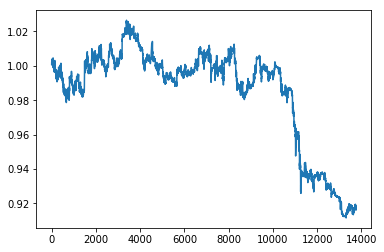

In [35]:
plt.plot(x)
x[-1]

In [67]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p,predict=True)
    newy_test = denormalize(stock_name, normalized_value_y_test,predict=False)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()